# GTD Project Dashboard

## Goals
* Demonstrate pulling video streams from external sources
* Explore Portfolio (multi-stream) concepts

In [1]:
import os
import json
import random
from datetime import datetime, timedelta
from io import BytesIO
from time import sleep

import cv2
import flask
from apscheduler.schedulers.background import BackgroundScheduler
import requests
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import yt_dlp
import matplotlib.pyplot as plt

In [2]:
ENVIRONMENT = os.getenv("ENVIRONMENT", "notebook")

In [3]:
model = YOLO("yolov8n.pt")

In [4]:
try:
    with open("GroundTruthPortfolio.json", "r") as f:
        groundTruthConfig = json.loads(f.read())
        groundTruthConfig['DATA'] = {sN: [(datetime.fromisoformat(d[0]), d[1]) for d in data] for sN, data in groundTruthConfig['DATA'].items()}
except FileNotFoundError:
    CAMERA_STREAMS = [
        'https://www.youtube.com/watch?v=ByED80IKdIU',
        'https://www.youtube.com/watch?v=NAk9Ku-n0Sk',
        'https://www.youtube.com/watch?v=_XBMMTQVj68']
    groundTruthConfig = {
        "CLASSES_OF_INTEREST": [2, 5, 6, 7],
        "COUNT_CLASSES": [7],
        "ACTIVE_ZONE": [(0, 0), (1920, 0), (1920, 1080), (0, 1080)],
        "STREAMS": CAMERA_STREAMS,
        "DATA": {stream: [(datetime.utcnow(), {c: 0 for c in [2, 5, 6, 7]})] for stream in CAMERA_STREAMS}
    }

CLASSES_OF_INTEREST = groundTruthConfig['CLASSES_OF_INTEREST']
COUNT_CLASSES = groundTruthConfig['COUNT_CLASSES']
ACTIVE_ZONE = groundTruthConfig['ACTIVE_ZONE']
CAMERA_STREAMS = groundTruthConfig['STREAMS']
DATA = groundTruthConfig['DATA']

In [5]:
def get_youtube_stream_url(youtube_url):
    ydl_opts = {
        'format': 'best',
        'quiet': True,
        'no_warnings': True,
        'extract_flat': True,
        'force_generic_extractor': True
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_url, download=False)
        return info['url']

In [6]:
YOUTUBE_STREAMS = {sN: get_youtube_stream_url(sN) for sN in CAMERA_STREAMS}

In [7]:
def get_frame_from_stream(youtube_stream):
    cap = cv2.VideoCapture(youtube_stream)
    if not cap.isOpened():
        print(f"Error: Unable to open video stream from URL: {url}")
        return None

    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print("Error: Unable to retrieve frame from video stream.")
        return None

    return frame

In [8]:
def collect_stream_image(youtube_stream, rotate=None):
    try:
        image = get_frame_from_stream(youtube_stream)
        image = cv2.resize(image, (1920, 1080))
        if rotate:
            images = cv2.rotate(image, rotate)
        return image
    except Exception as e:
        print(f"Failed to collect image: {e}")
        raise

In [9]:
def collect_images(count=5):
    images = {}
    for i in range(count):
        for sN, stream in YOUTUBE_STREAMS.items():
            if sN not in images:
                images[sN] = []
            images[sN].append(collect_stream_image(stream))
    return images

In [10]:
def cropToActiveZone(image):
    pts = np.int32(ACTIVE_ZONE)
    mask = np.zeros(image.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(image, image, mask=mask)
    return dst
        
def drawActiveZone(image):
    pts = np.int32(ACTIVE_ZONE)
    azOverlaidImage = image.copy()
    return cv2.polylines(azOverlaidImage, [pts], isClosed=True, color=(255, 255, 0), thickness=5)

In [11]:
def process_frame(frame):
    # Use YOLOv8 model to detect objects
    result = model(frame, verbose=False)[0]
    
    # Parse the results to count the number of trucks
    truck_count = 0
    for detection in result.boxes:  # Iterate through detections
        for idx, label_num in enumerate(detection.cls):
            label = result.names[int(label_num)]
            if label == 'truck':  # Assuming 'truck' is the label for trucks
                truck_count += 1
                
    return truck_count, result

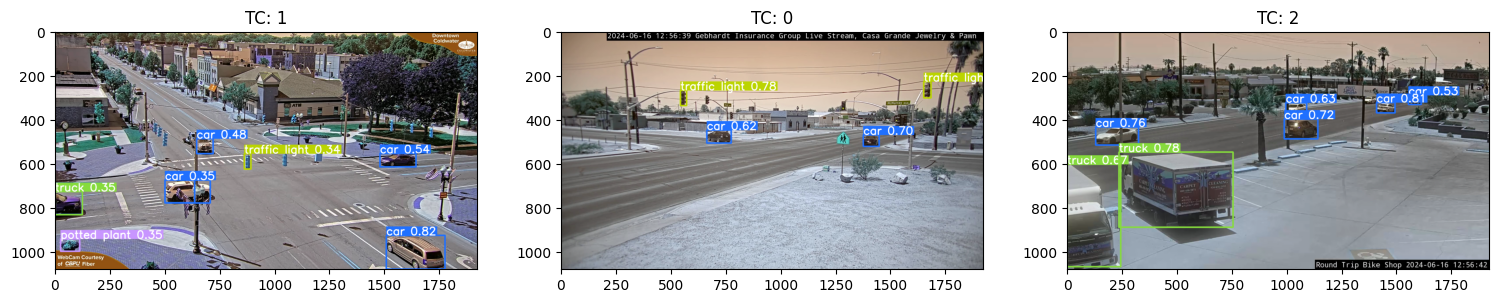

In [12]:
if ENVIRONMENT == "notebook":
    fig, axes = plt.subplots(1, len(YOUTUBE_STREAMS))
    for (streamName, stream), ax in zip(YOUTUBE_STREAMS.items(), axes):
        frame = collect_stream_image(stream)
        truck_count, results = process_frame(frame)
        ax.imshow(results.plot())
        ax.set_title(f"TC: {truck_count}")
    
    fig.set_size_inches(18.5, 10.5)

In [13]:
ANNOTATED_IMAGE = None

def captureAndAnalyzeStreams():
    while True:
        stream_images = []
        for stream_name, stream in YOUTUBE_STREAMS.items():
            camImage = collect_stream_image(stream)
            results = model(cropToActiveZone(camImage), verbose=False)[0]
        
            annotatedImage = camImage.copy()
            recognitions = 0
            if len(results.boxes) > 0:
                print(f"Detections at {datetime.utcnow()} - {[results.names[int(i)] for i in results.boxes.cls]}")
            recognitions = {c: 0 for c in CLASSES_OF_INTEREST}
            for box in results.boxes:
                if box.cls[0] in CLASSES_OF_INTEREST:
                    label = results.names[int(box.cls[0])]
                    print(f"Saw {label}: {box.xyxy}")
                    x1, y1, x2, y2 = [int(i) for i in box.xyxy[0]]
                    color = (0, 255, 0) if box.cls[0] in COUNT_CLASSES else (255, 0, 0)
                    cv2.rectangle(annotatedImage, (x1, y1), (x2, y2), color, 2)
                    cv2.rectangle(annotatedImage, (x1, y1 - 25), (x2, y1), color, -1)
                    cv2.putText(annotatedImage, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                    recognitions[int(box.cls[0])] += 1
            DATA[stream_name].append((datetime.utcnow(), recognitions))
            stream_images.append(drawActiveZone(annotatedImage))
        global ANNOTATED_IMAGE
        combined = np.concatenate(stream_images, axis=0)
        ret, encodedImage = cv2.imencode('.jpg', combined)
        ANNOTATED_IMAGE = encodedImage.tobytes()
        print("Cycle complete")

In [14]:
def camStream():
    while ANNOTATED_IMAGE is None:
            sleep(5)

    while True:
        yield(b'--frame\r\n'
              b'Content-Type: image/jpg\r\n\r\n' + ANNOTATED_IMAGE + b'\r\n')

In [15]:
ANALYZER_IMAGE = None

def buildAnalyzer():
    while True:
        fig, ax = plt.subplots()
        for idx, (sN, stream_data) in enumerate(DATA.items()):
            x, y = zip(*stream_data)
            y = [sum([v for k, v in yi.items() if k in COUNT_CLASSES]) for yi in y]
            ax.plot(x, y, label=f"Stream {idx}")
        plt.xlabel("Time")
        plt.ylabel("Number of Recognized Trucks")
        ax.legend()
        fig.autofmt_xdate()
        img_bytes = BytesIO()
        plt.savefig(img_bytes, format="jpg")
        img_bytes.seek(0)
        plt.close(fig)

        global ANALYZER_IMAGE
        ANALYZER_IMAGE = img_bytes.read()

In [16]:
def dataStream():
    while ANALYZER_IMAGE is None:
        sleep(5)

    while True:
        yield(b'--frame\r\n'
              b'Content-Type: image/jpg\r\n\r\n' + ANALYZER_IMAGE + b'\r\n')

In [17]:
def generate_oot(*args, **kwargs):
    with open('templates/OOT.html', 'r') as f:
        ootTemplate = f.read().replace("{active_zone}", json.dumps(ACTIVE_ZONE))
    return ootTemplate

In [18]:
app = flask.Flask(__name__)

@app.route('/')
def index():
    return flask.Response(generate_oot(), mimetype="text/html")

@app.route('/observer')
def observer():
    return flask.Response(camStream(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/analyzer')
def analyzer():
    return flask.Response(dataStream(), mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/active_zone', methods=['POST'])
def set_active_zone():
    new_active_zone = json.loads(flask.request.form['az'])
    if new_active_zone == []:
        new_active_zone = [(0, 0), (1920, 0), (1920, 1080), (0, 1080)]
    global ACTIVE_ZONE
    ACTIVE_ZONE = new_active_zone
    return json.dumps(ACTIVE_ZONE)

def saveState(snapshot=False):
    global DATA
    state = json.dumps({
        "CLASSES_OF_INTEREST": CLASSES_OF_INTEREST,
        "COUNT_CLASSES": COUNT_CLASSES,
        "ACTIVE_ZONE": ACTIVE_ZONE,
        "STREAMS": CAMERA_STREAMS,
        "DATA": {sN: [(d[0].isoformat(), d[1]) for d in stream_data] for sN, stream_data in DATA.items()}
    })
    with open("GroundTruthPortfolio.json", "w") as f:
        f.write(state)

    if snapshot:
        with open(f"GroundTruthPortfolio-{datetime.utcnow().isoformat()}.json", "w") as f:
            f.write(state)
        DATA =  [(datetime.utcnow(), {c: 0 for c in CLASSES_OF_INTEREST})]

@app.route('/save', methods=['POST'])
def saveRequest():
    saveState(snapshot=True)
    return "saved"

@app.route('/clear_data', methods=['POST'])
def clearData():
    global DATA
    DATA =  [(datetime.utcnow(), {c: 0 for c in CLASSES_OF_INTEREST})]
    saveState()
    return "cleared"

@app.route('/bootstrap.min.css', methods=['GET'])
def getBSCSS():
    with open("templates/bootstrap.min.css", "r") as f:
        bscss = f.read()
    return flask.Response(bscss, mimetype="text/css")
    
@app.route('/bootstrap.min.js', methods=['GET'])
def getBSJS():
    with open("templates/bootstrap.min.js", "r") as f:
        bsjs = f.read()
    return flask.Response(bsjs, mimetype="application/javascript")
    
@app.route('/htmx.min.js', methods=['GET'])
def getHTMX():
    with open("templates/htmx.min.js", "r") as f:
        htmx = f.read()
    return flask.Response(htmx, mimetype="application/javascript")


## Periodic tasks for capturing images and analyzing data
scheduler = BackgroundScheduler(daemon=True)
scheduler.add_job(captureAndAnalyzeStreams, 'interval', seconds=10)
scheduler.add_job(buildAnalyzer, 'interval', seconds=5)
scheduler.add_job(saveState, 'interval', seconds=300)

<Job (id=880f96f954124a2e99efa155f69d0a32 name=saveState)>

In [ ]:
if __name__ == "__main__":
    print(f"Launching Observer Server on 1337")
    scheduler.start()
    app.run(host="0.0.0.0", port=1337)

Launching Observer Server on 1337
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:1337
 * Running on http://192.168.2.204:1337
Press CTRL+C to quit
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:57:36.131504 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'person', 'car', 'car']
Saw car: tensor([[901.5108, 535.6732, 995.9324, 599.1281]])
Saw car: tensor([[2.0993e-01, 7.3730e+02, 1.9124e+02, 8.4036e+02]])
Saw car: tensor([[418.8803, 315.1479, 468.0322, 355.5172]])
Saw car: tensor([[1617.2761,  618.8793, 1784.2361,  700.1949]])
Saw car: tensor([[718.1880, 424.0779, 800.1848, 480.8866]])
Saw car: tensor([[642.5994, 476.5438, 719.0641, 557.9314]])
Saw car: tensor([[ 932.6662,  744.5933, 1101.6339,  885.8807]])
Saw car: tensor([[ 981.5804,  764.8096, 1102.9999,  881.3273]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:57:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:57:43.464317 - ['traffic light', 'traffic light', 'truck']
Saw truck: tensor([[1226.6998,  456.2866, 1384.1570,  540.9544]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:57:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:57:49.296526 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1029.6870,  322.4361, 1143.8547,  378.1857]])
Saw car: tensor([[344.8053, 374.6487, 549.8371, 478.5503]])
Saw truck: tensor([[240.0698, 550.3354, 755.4562, 886.6956]])
Saw truck: tensor([[5.4881e-01, 6.0543e+02, 2.4536e+02, 1.0701e+03]])
Saw car: tensor([[ 907.9708,  400.7996, 1086.2556,  498.1218]])
Saw car: tensor([[1294.9377,  333.9904, 1391.2972,  382.5469]])
Saw car: tensor([[745.1331, 325.5128, 830.6613, 383.0786]])
Saw car: tensor([[744.8863, 330.2137, 809.1808, 381.9102]])
Saw car: tensor([[  0.6768, 362.3571,  63.7181, 398.1118]])
Saw car: tensor([[1531.3704,  263.8043, 1587.2996,  291.3428]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:57:57.309720 - ['car', 'car', 'car', 'car', 'person', 'car', 'traffic light', 'person']
Saw car: tensor([[514.1387, 397.8396, 577.2736, 447.5446]])
Saw car: tensor([[4.1639e-01, 7.3744e+02, 1.8913e+02, 8.3881e+02]])
Saw car: tensor([[1640.7726,  612.8994, 1759.1210,  707.7068]])
Saw car: tensor([[1639.2810,  608.0338, 1847.6089,  712.0424]])
Saw car: tensor([[820.1248, 648.5825, 954.6454, 773.2528]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:57:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:57:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:58:03.601779 - ['car', 'traffic light', 'car', 'traffic light', 'car']
Saw car: tensor([[  0.0000, 508.5419, 309.1813, 649.5643]])
Saw car: tensor([[1749.4790,  480.3627, 1919.3679,  564.0361]])
Saw car: tensor([[1207.2061,  430.8900, 1283.4351,  480.3593]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:58:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:58:09.971711 - ['car', 'car', 'truck', 'truck', 'car']
Saw car: tensor([[1164.6335,  368.7945, 1292.1772,  446.1936]])
Saw car: tensor([[1232.4138,  302.5215, 1312.1925,  345.7193]])
Saw truck: tensor([[252.6310, 551.2240, 755.2121, 884.2313]])
Saw truck: tensor([[5.8823e-01, 6.0531e+02, 2.4572e+02, 1.0691e+03]])
Saw car: tensor([[  1.1171, 363.6194,  65.3139, 398.1964]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:13 EDT)" skipped: maximum number of running instances reached (1)
192.168.2.102 - - [16/Jun/2024 15:58:14] "GET / HTTP/1.1" 200 -
192.168.2.102 - - [16/Jun/2024 15:58:14] "GET /bootstrap.min.css HTTP/1.1" 200 -
192.168.2.102 - - [16/Jun/2024 15:58:14] "GET /bootstrap.min.js HTTP/1.1" 200 -
192.168.2.102 - - [16/Jun/2024 15:58:14] "GET /htmx.min.js HTTP/1.1" 200 -
192.168.2.102 - - [16/Jun/2024 15:58:14] "GET /observer HTTP/1.1" 200 -
192.168.2.102 - - [16/Jun/2024 15:58:14] "GET /analyzer HTTP/1.1" 200 -


Detections at 2024-06-16 19:58:17.754561 - ['car', 'car', 'truck', 'potted plant', 'car']
Saw car: tensor([[ 819.6248,  667.5110, 1029.3076,  746.2658]])
Saw car: tensor([[1361.5457,  828.8354, 1539.5989,  940.5737]])
Saw truck: tensor([[ 50.2069, 713.7451, 343.4250, 833.6477]])
Saw car: tensor([[1162.7794, 1040.4530, 1309.5703, 1080.0000]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:58:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:58:27.546938 - ['traffic light', 'traffic light', 'car', 'car']
Saw car: tensor([[401.2085, 527.4985, 749.0574, 662.2363]])
Saw car: tensor([[1441.0186,  409.9182, 1482.8867,  440.1437]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:58:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:58:36.034684 - ['truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw truck: tensor([[260.5063, 550.0178, 755.3557, 893.0636]])
Saw truck: tensor([[5.9766e-01, 6.0528e+02, 2.4583e+02, 1.0698e+03]])
Saw car: tensor([[ 972.1370,  399.5546, 1132.8146,  490.8411]])
Saw car: tensor([[1505.5602,  311.1147, 1585.6930,  366.2151]])
Saw car: tensor([[638.7098, 311.7767, 778.0236, 384.9065]])
Saw car: tensor([[1312.2419,  295.1288, 1397.0509,  339.3235]])
Saw car: tensor([[2.6321e-01, 3.6354e+02, 6.3842e+01, 3.9879e+02]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:58:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:58:47.581170 - ['car', 'potted plant', 'car']
Saw car: tensor([[1525.2202,  564.4862, 1698.9551,  645.4336]])
Saw car: tensor([[468.8293, 257.8273, 508.1943, 287.8813]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:58:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:58:56.280016 - ['car', 'traffic light', 'car', 'traffic light']
Saw car: tensor([[384.5467, 544.6262, 670.6827, 674.7503]])
Saw car: tensor([[471.0240, 450.6745, 603.0330, 503.3664]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:58:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:58:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:59:05.179120 - ['car', 'car', 'car', 'truck', 'car', 'truck', 'car', 'car']
Saw car: tensor([[795.4407, 435.7337, 989.0273, 525.1207]])
Saw car: tensor([[ 955.3759,  368.0702, 1090.3510,  443.5078]])
Saw car: tensor([[1214.3914,  333.5944, 1316.6671,  395.1896]])
Saw truck: tensor([[248.8418, 549.0745, 754.8669, 885.2602]])
Saw car: tensor([[548.9448, 343.7158, 721.4894, 429.0186]])
Saw truck: tensor([[5.6946e-01, 6.0472e+02, 2.4578e+02, 1.0687e+03]])
Saw car: tensor([[1463.3876,  305.5477, 1528.9199,  348.3321]])
Saw car: tensor([[3.4323e-01, 3.6454e+02, 6.4079e+01, 3.9891e+02]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:59:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:59:17.060767 - ['car', 'car', 'car', 'car', 'traffic light', 'potted plant', 'car', 'car', 'car', 'truck']
Saw car: tensor([[1524.1353,  566.3801, 1701.9698,  645.2095]])
Saw car: tensor([[248.0607, 624.3729, 457.0408, 713.9688]])
Saw car: tensor([[1393.2518,  946.4324, 1638.1558, 1079.1586]])
Saw car: tensor([[796.0909, 460.2513, 887.9480, 531.3439]])
Saw car: tensor([[474.5701, 259.1084, 514.9164, 291.6224]])
Saw car: tensor([[409.3927, 277.4663, 469.0976, 322.1133]])
Saw car: tensor([[1420.1156,  547.5168, 1579.6851,  621.9955]])
Saw truck: tensor([[3.0466e-01, 7.3656e+02, 2.3602e+02, 8.5224e+02]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:59:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:59:26.706190 - ['traffic light', 'traffic light', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1002.5508,  438.7203, 1106.6279,  490.9224]])
Saw car: tensor([[1097.9385,  440.1343, 1196.1361,  498.2568]])
Saw car: tensor([[1285.5062,  437.1787, 1342.2169,  471.2776]])
Saw car: tensor([[1145.7733,  447.0169, 1240.1799,  502.1440]])
Saw car: tensor([[1101.2693,  442.7442, 1240.7319,  499.2476]])
Saw car: tensor([[1096.4161,  443.5772, 1166.8865,  497.2820]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:59:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:59:35.764017 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[564.4166, 466.9939, 802.7989, 584.3185]])
Saw car: tensor([[381.0084, 374.5085, 562.9642, 449.3180]])
Saw truck: tensor([[245.2846, 548.6710, 753.8873, 886.8052]])
Saw truck: tensor([[5.6360e-01, 6.0473e+02, 2.4542e+02, 1.0696e+03]])
Saw car: tensor([[ 955.5559,  335.8971, 1065.5054,  386.8477]])
Saw car: tensor([[1221.1824,  299.2349, 1318.5052,  349.6350]])
Saw car: tensor([[1166.7466,  305.2720, 1226.7799,  343.2269]])
Saw car: tensor([[1199.0457,  291.5262, 1320.5453,  349.5204]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:59:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:59:47.684723 - ['car', 'car', 'car', 'car', 'car', 'traffic light', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[1521.3916,  564.8362, 1699.4954,  646.3718]])
Saw car: tensor([[  0.0000, 801.9155, 278.0706, 914.3174]])
Saw car: tensor([[1173.4137,  553.0778, 1385.5389,  639.5061]])
Saw car: tensor([[228.8824, 707.8233, 489.1013, 820.1309]])
Saw car: tensor([[1393.1741,  845.0828, 1661.6870, 1015.0087]])
Saw truck: tensor([[  1.4006, 648.5651, 221.0607, 785.3080]])
Saw car: tensor([[504.9569, 461.7591, 558.3549, 521.0477]])
Saw car: tensor([[1785.8383,  569.7060, 1886.9762,  625.5793]])
Saw car: tensor([[1731.6962,  567.7976, 1887.4266,  626.9936]])
Saw car: tensor([[1673.8781,  550.1846, 1791.2128,  602.2339]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:59:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 19:59:58.309065 - ['traffic light', 'traffic light', 'car', 'car', 'car']
Saw car: tensor([[ 941.0376,  474.0638, 1127.1647,  566.4251]])
Saw car: tensor([[1363.3531,  447.9249, 1465.2466,  513.6628]])
Saw car: tensor([[1084.6440,  449.1032, 1193.3779,  510.4976]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 15:59:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 15:59:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:00:07.335974 - ['car', 'car', 'car', 'truck', 'truck', 'car']
Saw car: tensor([[1126.3778,  303.6868, 1208.6112,  347.6912]])
Saw car: tensor([[1504.5256,  304.7000, 1593.8950,  363.9344]])
Saw car: tensor([[1223.6129,  342.5015, 1314.8749,  395.0733]])
Saw truck: tensor([[250.8970, 549.3358, 754.8016, 890.0102]])
Saw truck: tensor([[6.3567e-01, 6.0369e+02, 2.4456e+02, 1.0693e+03]])
Saw car: tensor([[729.7324, 378.5154, 943.3429, 484.9287]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:00:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:00:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:00:20.836638 - ['car', 'car', 'car', 'car', 'car', 'truck', 'potted plant', 'stop sign']
Saw car: tensor([[1855.9325,  568.0062, 1918.8285,  621.3823]])
Saw car: tensor([[124.4636, 738.6791, 366.3762, 833.9011]])
Saw car: tensor([[1389.3564,  839.5749, 1659.5427, 1008.8581]])
Saw car: tensor([[1200.4149,  611.6876, 1363.9556,  722.6177]])
Saw car: tensor([[511.5901, 490.6914, 619.5211, 580.2891]])
Saw truck: tensor([[124.3538, 739.4358, 368.4989, 831.2615]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:00:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:00:31.359408 - ['car', 'car', 'traffic light', 'traffic light', 'truck', 'bus']
Saw car: tensor([[1353.1157,  490.3886, 1554.4984,  552.5980]])
Saw car: tensor([[ 996.2250,  444.0604, 1090.1757,  492.0541]])
Saw truck: tensor([[1644.8273,  427.9315, 1919.6796,  592.9847]])
Saw bus: tensor([[1643.0771,  426.9342, 1918.9592,  595.2460]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:00:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:00:40.521977 - ['truck', 'truck', 'car']
Saw truck: tensor([[5.8095e-01, 6.0534e+02, 2.4526e+02, 1.0700e+03]])
Saw truck: tensor([[256.4878, 550.1207, 754.8648, 887.3167]])
Saw car: tensor([[1183.1108,  252.5798, 1232.1963,  284.1430]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:00:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:00:52.365984 - ['car', 'car', 'potted plant', 'car', 'car', 'car', 'car', 'car', 'traffic light', 'person']
Saw car: tensor([[1488.6913,  581.2791, 1661.2266,  646.0140]])
Saw car: tensor([[121.4687, 737.8634, 364.4408, 829.6523]])
Saw car: tensor([[447.8528, 246.4500, 489.2987, 278.9153]])
Saw car: tensor([[668.5616, 514.6714, 754.5077, 579.5831]])
Saw car: tensor([[1783.7219,  554.9216, 1910.3994,  624.7544]])
Saw car: tensor([[505.2124, 283.2472, 551.6503, 315.8923]])
Saw car: tensor([[407.8747, 218.0170, 448.8846, 252.0932]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:00:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:00:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:01:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:01:08.857467 - ['car', 'traffic light', 'traffic light', 'car', 'car']
Saw car: tensor([[477.7936, 444.7189, 604.9319, 503.1426]])
Saw car: tensor([[1402.3722,  457.9453, 1486.2927,  512.1423]])
Saw car: tensor([[1475.7290,  476.2834, 1723.3711,  560.6855]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:01:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:01:18.635460 - ['car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1176.4333,  311.0363, 1259.9979,  357.0768]])
Saw truck: tensor([[249.9971, 549.0430, 754.1249, 886.2964]])
Saw truck: tensor([[5.3183e-01, 6.0438e+02, 2.4395e+02, 1.0701e+03]])
Saw car: tensor([[1378.1299,  319.1797, 1479.8230,  395.2899]])
Saw car: tensor([[1257.2179,  383.9064, 1382.4635,  456.8791]])
Saw car: tensor([[1482.0946,  322.9916, 1550.2831,  371.0420]])
Saw car: tensor([[509.7631, 466.9362, 748.3173, 583.5015]])
Saw car: tensor([[1290.8103,  354.0678, 1396.5416,  413.1865]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:01:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:01:33.383533 - ['car', 'car', 'car', 'car', 'potted plant', 'car', 'truck', 'stop sign', 'car']
Saw car: tensor([[1270.2299,  891.0095, 1469.8511, 1035.1256]])
Saw car: tensor([[1209.7482,  605.1513, 1380.2211,  674.0746]])
Saw car: tensor([[1619.2665,  556.9985, 1803.3292,  639.9268]])
Saw car: tensor([[1692.6826, 1028.7543, 1856.8843, 1080.0000]])
Saw car: tensor([[1456.5614,  851.4313, 1638.9587,  980.6261]])
Saw truck: tensor([[1454.2048,  848.7244, 1640.3807,  989.1326]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:33 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1210.5494,  605.6924, 1302.6658,  672.8284]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:01:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:01:45.031958 - ['car', 'car', 'traffic light', 'car', 'traffic light']
Saw car: tensor([[163.5359, 514.2970, 457.7769, 614.0172]])
Saw car: tensor([[639.4722, 488.4974, 845.0481, 582.8159]])
Saw car: tensor([[ 962.5106,  460.7265, 1062.0104,  511.9803]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:01:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:01:55.154899 - ['car', 'car', 'car', 'car', 'truck', 'car', 'car', 'car', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[641.6470, 438.2073, 871.9135, 565.7635]])
Saw car: tensor([[320.7651, 387.2246, 514.4070, 481.4371]])
Saw car: tensor([[1427.6495,  338.8703, 1504.1283,  390.1981]])
Saw car: tensor([[1061.9155,  395.3641, 1207.9465,  481.9259]])
Saw truck: tensor([[244.8383, 550.3660, 754.7794, 890.0081]])
Saw car: tensor([[1283.0234,  349.3289, 1386.5850,  415.8009]])
Saw car: tensor([[690.3701, 335.3782, 813.3439, 409.3237]])
Saw car: tensor([[ 76.1166, 522.3505, 357.4728, 682.6088]])
Saw truck: tensor([[5.4066e-01, 6.0129e+02, 2.4597e+02, 1.0698e+03]])
Saw car: tensor([[1530.9830,  315.5061, 1587.2045,  367.5653]])
Saw car: tensor([[1356.5244,  290.6645, 1420.9567,  319.8601]])
Saw car: tensor([[1282.7960,  297.9241, 1348.0087,  344.0592]])
Saw car: tensor([[1475.4089,  274.9308, 1514.8068,  310.4790]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:01:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:01:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:02:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:02:08.991727 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'car', 'car', 'car']
Saw car: tensor([[ 46.4815, 738.7427, 308.3598, 840.7826]])
Saw car: tensor([[1591.4344,  537.5054, 1778.8744,  611.0576]])
Saw car: tensor([[742.0604, 427.8007, 819.5156, 481.6122]])
Saw car: tensor([[589.3854, 333.3278, 648.8033, 378.4574]])
Saw car: tensor([[1525.1021,  529.3045, 1632.2393,  588.4236]])
Saw car: tensor([[1506.1224,  744.2869, 1675.2240,  866.2703]])
Saw car: tensor([[426.8488, 229.4493, 489.7253, 276.1162]])
Saw car: tensor([[1588.3767,  537.4787, 1721.8914,  609.9910]])
Saw car: tensor([[1567.1375,  762.7681, 1675.5396,  869.0277]])
Saw car: tensor([[1680.2838,  614.9711, 1757.0021,  687.9212]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:02:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:02:20.782903 - ['traffic light', 'car', 'traffic light', 'car', 'truck', 'truck', 'car']
Saw car: tensor([[1589.9084,  499.7643, 1862.5774,  589.5030]])
Saw car: tensor([[1302.0159,  476.0278, 1505.2172,  551.1299]])
Saw truck: tensor([[1297.7048,  475.4936, 1505.4120,  551.8282]])
Saw truck: tensor([[ 886.4182,  475.2156, 1150.9531,  559.0941]])
Saw car: tensor([[877.1141, 486.6749, 943.1633, 549.0950]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:02:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:02:36.454731 - ['truck', 'truck']
Saw truck: tensor([[255.8298, 550.2231, 755.1555, 888.9478]])
Saw truck: tensor([[5.9507e-01, 6.0409e+02, 2.4655e+02, 1.0688e+03]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:02:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:02:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:02:51.383062 - ['car', 'car', 'potted plant', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[278.0470, 716.8380, 528.7344, 812.5464]])
Saw car: tensor([[1212.4698,  544.5624, 1330.0331,  600.5361]])
Saw car: tensor([[1813.7528,  565.5496, 1918.5470,  625.9670]])
Saw car: tensor([[1489.9927,  546.1683, 1686.7999,  648.1875]])
Saw car: tensor([[1493.4753,  586.4751, 1652.6412,  648.7997]])
Saw car: tensor([[657.5694, 487.5571, 740.0363, 565.7986]])
Saw car: tensor([[351.8448, 183.2931, 389.5402, 211.8070]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:02:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:02:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:03:03.436909 - ['car', 'car', 'car', 'traffic light', 'traffic light']
Saw car: tensor([[126.0197, 634.9598, 613.4290, 823.2986]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:03 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[237.1179, 502.2263, 586.9396, 632.8282]])
Saw car: tensor([[1629.4750,  480.5949, 1917.6251,  569.9951]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:03:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:03:15.351133 - ['truck', 'car', 'truck', 'car', 'car', 'car', 'car']
Saw truck: tensor([[253.8881, 549.2592, 755.0496, 885.1793]])
Saw car: tensor([[ 954.8337,  321.0173, 1097.5610,  414.0180]])
Saw truck: tensor([[5.4817e-01, 6.0237e+02, 2.4566e+02, 1.0699e+03]])
Saw car: tensor([[4.8351e-01, 5.2566e+02, 1.9491e+02, 6.3701e+02]])
Saw car: tensor([[1452.1633,  334.9350, 1525.2177,  383.8483]])
Saw car: tensor([[738.9146, 416.8410, 959.9174, 532.3911]])
Saw car: tensor([[1001.4781,  320.3788, 1096.0748,  410.5724]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:03:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:03:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:03:29.307257 - ['car', 'car', 'car', 'car', 'car', 'traffic light', 'car', 'car', 'potted plant']
Saw car: tensor([[ 66.5537, 785.4174, 349.3963, 899.0680]])
Saw car: tensor([[746.3923, 431.6526, 820.2512, 480.9013]])
Saw car: tensor([[869.4291, 505.7476, 958.7472, 573.8751]])
Saw car: tensor([[1526.1553,  682.8748, 1631.4856,  769.2484]])
Saw car: tensor([[1474.6647,  545.1747, 1676.1482,  646.6187]])
Saw car: tensor([[601.3788, 348.4216, 655.8589, 384.9123]])
Saw car: tensor([[ 943.9609, 1006.0157, 1121.7534, 1080.0000]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:03:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:03:41.858850 - ['car', 'car', 'traffic light', 'traffic light', 'car']
Saw car: tensor([[809.9607, 465.2604, 942.4503, 531.3630]])
Saw car: tensor([[295.1125, 495.9604, 544.9619, 603.1344]])
Saw car: tensor([[1087.3004,  446.6265, 1190.8250,  498.2640]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:03:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:03:52.596441 - ['car', 'car', 'car', 'truck', 'truck', 'car']
Saw car: tensor([[338.4321, 385.7953, 548.3129, 484.2351]])
Saw car: tensor([[1498.8318,  563.4778, 1684.9944,  705.9725]])
Saw car: tensor([[1069.2788,  316.4126, 1160.8198,  374.0293]])
Saw truck: tensor([[247.5235, 550.1824, 754.5511, 890.9913]])
Saw truck: tensor([[5.9429e-01, 6.0479e+02, 2.4632e+02, 1.0696e+03]])
Saw car: tensor([[2.9127e-01, 3.6374e+02, 6.4593e+01, 3.9869e+02]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:53 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:03:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:03:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:04:08.504942 - ['traffic light', 'car', 'car', 'car', 'potted plant', 'car', 'car', 'traffic light', 'car', 'car', 'car']
Saw car: tensor([[1705.0862,  545.5117, 1793.9806,  600.7061]])
Saw car: tensor([[1453.5430,  550.2574, 1677.1517,  644.9623]])
Saw car: tensor([[1707.9899,  524.2361, 1890.2384,  599.8854]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:04:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:08 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[843.2483, 690.7867, 977.9421, 797.5718]])
Saw car: tensor([[1706.2192,  537.0101, 1823.7891,  600.9711]])
Saw car: tensor([[364.9926, 265.7466, 408.9934, 300.4971]])
Saw car: tensor([[873.0905, 713.1824, 976.1715, 800.4186]])
Saw car: tensor([[413.8530, 215.5620, 450.9870, 251.0350]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:04:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:04:19.778440 - ['traffic light', 'car', 'traffic light', 'car', 'car']
Saw car: tensor([[ 992.4362,  444.2714, 1078.3185,  491.2518]])
Saw car: tensor([[1376.9066,  427.9639, 1427.8425,  459.0017]])
Saw car: tensor([[1101.5220,  442.0302, 1172.2467,  482.5999]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:04:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:04:30.860050 - ['truck', 'truck']
Saw truck: tensor([[5.9889e-01, 6.0528e+02, 2.4370e+02, 1.0698e+03]])
Saw truck: tensor([[253.6243, 550.0914, 754.9951, 889.5679]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:04:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:04:46.553465 - ['car', 'car', 'car', 'car', 'potted plant', 'car', 'car']
Saw car: tensor([[1532.0885,  811.4832, 1743.7555,  931.5874]])
Saw car: tensor([[1432.7074,  594.0333, 1662.0430,  695.9610]])
Saw car: tensor([[710.5853, 482.2705, 812.5818, 545.2701]])
Saw car: tensor([[1381.7520,  842.9196, 1653.2717, 1016.7131]])
Saw car: tensor([[1105.7070,  398.2272, 1163.0363,  427.0418]])
Saw car: tensor([[1407.2007,  843.4052, 1579.2477,  917.5448]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:04:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:04:57.867080 - ['car', 'car', 'traffic light', 'car', 'traffic light', 'car']
Saw car: tensor([[758.0942, 554.4393, 983.4573, 660.9218]])
Saw car: tensor([[406.2921, 525.9385, 661.3836, 613.6245]])
Saw car: tensor([[ 992.5686,  447.7844, 1081.5560,  491.6818]])
Saw car: tensor([[1437.6932,  419.7884, 1489.3229,  449.4704]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:04:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:04:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:05:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:05:09.892640 - ['truck', 'car', 'truck', 'car', 'car', 'car']
Saw truck: tensor([[257.7644, 546.0620, 755.0126, 889.3717]])
Saw car: tensor([[1186.7103,  351.6418, 1329.1550,  442.7157]])
Saw truck: tensor([[5.3996e-01, 6.0586e+02, 2.4414e+02, 1.0706e+03]])
Saw car: tensor([[1468.6528,  283.0779, 1518.6053,  317.8000]])
Saw car: tensor([[195.2500, 520.0066, 432.0502, 666.6887]])
Saw car: tensor([[2.1360e-01, 3.6289e+02, 6.4444e+01, 3.9881e+02]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:05:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:05:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:05:29.964865 - ['car', 'car', 'truck', 'potted plant', 'car', 'person', 'person']
Saw car: tensor([[660.5071, 375.0098, 720.3351, 420.8116]])
Saw car: tensor([[1608.7808,  986.4002, 1871.7700, 1080.0000]])
Saw truck: tensor([[5.6177e-01, 7.1118e+02, 2.5383e+02, 8.3160e+02]])
Saw car: tensor([[452.0897, 247.0080, 488.5644, 280.3698]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:05:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:05:41.472622 - ['traffic light', 'car', 'traffic light', 'car', 'car']
Saw car: tensor([[1363.3444,  482.2199, 1557.9116,  551.8746]])
Saw car: tensor([[1317.8093,  451.1941, 1407.6354,  500.4028]])
Saw car: tensor([[1858.7556,  518.6527, 1919.1489,  570.6537]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:05:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:05:53.013684 - ['car', 'car', 'car', 'car', 'truck', 'truck']
Saw car: tensor([[538.7369, 378.8831, 691.7806, 453.6777]])
Saw car: tensor([[1469.0575,  301.4426, 1544.7896,  349.3941]])
Saw car: tensor([[1160.5005,  293.4503, 1246.9270,  343.4084]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:53 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1033.1206,  325.5279, 1133.5737,  377.0106]])
Saw truck: tensor([[6.3789e-01, 6.0476e+02, 2.4540e+02, 1.0701e+03]])
Saw truck: tensor([[256.5408, 549.7352, 754.2545, 885.5810]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:05:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:05:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:06:07.024637 - ['car', 'car', 'car', 'traffic light', 'traffic light', 'potted plant', 'car', 'car']
Saw car: tensor([[1251.9935,  607.3409, 1410.2981,  673.6123]])
Saw car: tensor([[1808.9650,  544.8304, 1919.5416,  626.7470]])
Saw car: tensor([[ 944.4922,  745.9219, 1062.0573,  877.3181]])
Saw car: tensor([[648.3125, 490.9033, 709.1027, 552.1923]])
Saw car: tensor([[1106.1556,  396.0519, 1162.8715,  422.2260]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:06:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:06:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:06:19.429491 - ['traffic light', 'car', 'traffic light', 'car', 'car', 'truck']
Saw car: tensor([[1044.8120,  450.1072, 1128.7552,  488.5253]])
Saw car: tensor([[1362.5681,  454.2115, 1433.0597,  489.4099]])
Saw car: tensor([[1470.1219,  479.1748, 1746.4849,  562.3652]])
Saw truck: tensor([[1470.4277,  480.1759, 1762.5681,  561.5161]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:06:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:06:29.975048 - ['truck', 'truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
Saw truck: tensor([[260.8426, 549.9791, 755.8396, 885.7066]])
Saw truck: tensor([[5.8976e-01, 6.0560e+02, 2.4633e+02, 1.0695e+03]])
Saw car: tensor([[683.7522, 444.8178, 869.3524, 557.9678]])
Saw car: tensor([[1542.9144,  298.8096, 1603.8069,  336.1758]])
Saw car: tensor([[1495.0184,  269.1273, 1549.8168,  311.7201]])
Saw car: tensor([[1297.9247,  324.3505, 1409.6110,  409.5657]])
Saw car: tensor([[1303.9010,  321.7938, 1409.7687,  379.9178]])
Saw car: tensor([[1492.7195,  277.5600, 1547.5994,  314.9513]])
Saw car: tensor([[1323.7745,  322.9437, 1410.1036,  369.8454]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:06:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:06:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:06:49.217020 - ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'potted plant']
Saw car: tensor([[1619.6071,  575.9801, 1783.9545,  644.3363]])
Saw car: tensor([[1324.0299,  543.5400, 1458.0060,  600.5970]])
Saw car: tensor([[1.8452e-01, 7.4760e+02, 1.8072e+02, 8.4499e+02]])
Saw car: tensor([[1465.5930,  553.3151, 1611.3289,  618.2411]])
Saw car: tensor([[469.6258, 264.3600, 512.7729, 296.5928]])
Saw car: tensor([[1250.9462,  775.1804, 1443.5145,  895.4188]])
Saw car: tensor([[376.1085, 200.5083, 416.1074, 230.6589]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:06:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:06:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:07:00.274978 - ['car', 'traffic light', 'traffic light', 'car', 'car', 'car']
Saw car: tensor([[807.6716, 465.7592, 926.4957, 516.1859]])
Saw car: tensor([[1379.6589,  462.0566, 1463.1550,  513.5629]])
Saw car: tensor([[1429.1005,  436.5301, 1490.6711,  478.2791]])
Saw car: tensor([[1380.3190,  450.6445, 1477.1998,  512.4410]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:07:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:07:10.268479 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[ 953.0632,  382.7196, 1091.7272,  444.8244]])
Saw car: tensor([[1183.0222,  298.6189, 1259.7870,  342.9836]])
Saw truck: tensor([[260.8351, 550.0339, 755.2097, 892.1132]])
Saw truck: tensor([[5.6834e-01, 6.0500e+02, 2.4705e+02, 1.0690e+03]])
Saw car: tensor([[1429.1116,  307.3508, 1501.2511,  356.0557]])
Saw car: tensor([[1237.9713,  335.7166, 1358.5305,  428.1916]])
Saw car: tensor([[1538.9675,  321.5179, 1592.1600,  364.9956]])
Saw car: tensor([[1.3862e-01, 3.6360e+02, 6.5289e+01, 3.9940e+02]])
Saw car: tensor([[1540.1068,  312.8837, 1607.2937,  364.3951]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:07:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:07:26.315212 - ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'truck', 'traffic light', 'person']
Saw car: tensor([[1500.5215,  568.5305, 1676.4500,  645.4588]])
Saw car: tensor([[266.5682, 714.6185, 507.1061, 822.0223]])
Saw car: tensor([[1126.0272,  659.6763, 1330.1713,  732.0125]])
Saw car: tensor([[1255.9432,  602.2217, 1426.3972,  675.3004]])
Saw car: tensor([[352.1909, 619.4081, 550.5097, 707.6888]])
Saw car: tensor([[1548.3651,  928.9364, 1873.6674, 1078.8263]])
Saw car: tensor([[505.1195, 661.3643, 641.0032, 743.2578]])
Saw car: tensor([[467.2208, 355.7380, 528.0881, 406.7040]])
Saw car: tensor([[653.0333, 494.9486, 738.6641, 570.3906]])
Saw car: tensor([[573.8513, 446.2689, 656.9801, 518.2593]])
Saw car: tensor([[1811.3075,  547.3411, 1919.3353,  624.0943]])
Saw car: tensor([[488.8632, 280.3316, 527.2851, 306.3176]])
Saw car: tensor([[383.5939, 200.6648, 420.4928, 232.9563]])
Saw truck: tensor([[573.8840,

Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:07:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:07:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:07:38.932698 - ['car', 'traffic light', 'traffic light', 'car']
Saw car: tensor([[4.3343e-01, 7.1631e+02, 2.6205e+02, 9.0255e+02]])
Saw car: tensor([[1350.5343,  435.8295, 1412.9500,  469.8688]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:07:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:07:50.365701 - ['car', 'car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[ 911.1085,  393.3122, 1113.4451,  495.1276]])
Saw car: tensor([[514.8697, 456.1168, 757.7231, 578.9886]])
Saw car: tensor([[1189.6451,  344.6972, 1326.6923,  435.7800]])
Saw truck: tensor([[248.4906, 548.2213, 754.9883, 892.1823]])
Saw truck: tensor([[5.7596e-01, 5.9887e+02, 2.4576e+02, 1.0694e+03]])
Saw car: tensor([[1519.8052,  290.1628, 1583.9723,  335.0892]])
Saw car: tensor([[1407.5142,  302.2496, 1463.8032,  356.5976]])
Saw car: tensor([[  1.1136, 413.1824, 196.2012, 492.1467]])
Saw car: tensor([[  2.4510, 463.9258, 299.1252, 606.2709]])
Saw car: tensor([[1454.5792,  326.0277, 1530.0187,  386.2548]])
Saw car: tensor([[ 940.9363,  316.7483, 1024.3683,  367.5385]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:07:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:07:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:08:05.552486 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'car', 'car', 'car', 'person', 'person']
Saw car: tensor([[162.0137, 726.5782, 375.3634, 816.7449]])
Saw car: tensor([[654.2346, 384.1319, 720.6650, 433.4643]])
Saw car: tensor([[ 900.8389,  723.6912, 1052.2808,  865.7963]])
Saw car: tensor([[ 18.5419, 687.2013, 246.6719, 791.7243]])
Saw car: tensor([[ 911.3724,  537.5099, 1033.2188,  615.3832]])
Saw car: tensor([[590.7635, 339.0580, 645.3503, 377.9152]])
Saw car: tensor([[713.3843, 545.4699, 836.7499, 646.1536]])
Saw car: tensor([[533.1299, 290.6817, 573.0742, 324.5360]])
Saw car: tensor([[711.9882, 544.0157, 828.8150, 620.8903]])
Saw car: tensor([[412.7310, 223.3801, 455.3620, 255.3369]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:08:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:08:17.731131 - ['traffic light', 'traffic light', 'car']
Saw car: tensor([[1407.6248,  416.3853, 1452.0652,  447.0126]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:08:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:08:28.479825 - ['truck', 'car', 'car', 'car', 'truck', 'car', 'car', 'car']
Saw truck: tensor([[267.0979, 549.6929, 755.5245, 891.8606]])
Saw car: tensor([[687.9932, 358.2026, 831.2450, 426.1088]])
Saw car: tensor([[ 982.0448,  409.5439, 1146.0393,  489.4985]])
Saw car: tensor([[1079.1935,  297.7570, 1181.3364,  356.6364]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:08:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:28 EDT)" skipped: maximum number of running instances reached (1)


Saw truck: tensor([[4.7081e-01, 5.8975e+02, 2.4562e+02, 1.0700e+03]])
Saw car: tensor([[1539.4622,  319.0979, 1595.4360,  362.9912]])
Saw car: tensor([[1491.1528,  274.0474, 1551.6790,  314.3486]])
Saw car: tensor([[686.1825, 318.9500, 789.2960, 372.8071]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:08:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:08:42.172351 - ['car', 'car', 'car', 'car', 'potted plant', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person', 'person', 'person', 'traffic light']
Saw car: tensor([[188.7729, 723.1033, 411.1440, 814.3453]])
Saw car: tensor([[762.5153, 445.9163, 839.9724, 499.4686]])
Saw car: tensor([[1025.3105,  621.1356, 1158.1539,  712.4302]])
Saw car: tensor([[623.8504, 352.7571, 682.5978, 396.8386]])
Saw car: tensor([[ 45.1490, 684.9088, 262.1254, 789.2992]])
Saw car: tensor([[506.0725, 275.0498, 558.5168, 313.3840]])
Saw car: tensor([[885.0463, 523.6945, 993.5425, 596.6298]])
Saw car: tensor([[1416.5941,  553.3616, 1587.9695,  619.3890]])
Saw car: tensor([[913.9807, 527.5432, 993.7883, 597.2084]])
Saw car: tensor([[1714.6364,  550.3982, 1794.4062,  600.4008]])
Saw car: tensor([[1714.8010,  545.8693, 1865.9883,  601.5498]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:08:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:08:56.363563 - ['car', 'traffic light', 'traffic light', 'car', 'car']
Saw car: tensor([[707.7853, 541.5658, 970.7277, 676.6061]])
Saw car: tensor([[513.2877, 451.4863, 622.1033, 504.3555]])
Saw car: tensor([[1537.1971,  497.1796, 1790.2837,  564.8679]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:08:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:08:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:09:07.862393 - ['car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1285.8893,  361.1330, 1393.2850,  416.8427]])
Saw truck: tensor([[262.3332, 550.5300, 755.0491, 893.3734]])
Saw truck: tensor([[5.2961e-01, 6.0496e+02, 2.4680e+02, 1.0696e+03]])
Saw car: tensor([[1381.7791,  295.9309, 1437.8236,  328.7833]])
Saw car: tensor([[ 959.2989,  365.1740, 1097.5497,  446.0386]])
Saw car: tensor([[1511.1918,  305.0131, 1586.1478,  363.4565]])
Saw car: tensor([[1008.6125,  369.0905, 1097.4116,  442.5758]])
Saw car: tensor([[3.8016e-01, 3.6296e+02, 6.4004e+01, 3.9996e+02]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:09:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:08 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:09:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:09:24.235218 - ['car', 'car', 'motorcycle', 'car', 'person', 'car', 'potted plant', 'person', 'car', 'person']
Saw car: tensor([[809.5274, 467.0078, 896.8134, 529.4720]])
Saw car: tensor([[1.5175e-01, 7.3990e+02, 2.6459e+02, 8.4054e+02]])
Saw car: tensor([[640.8662, 363.1378, 696.7250, 408.9320]])
Saw car: tensor([[1443.3069,  549.2981, 1614.7668,  619.6877]])
Saw car: tensor([[1378.7800,  547.1331, 1462.5288,  597.5192]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:09:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:09:37.340513 - ['traffic light', 'traffic light', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[463.4377, 443.6588, 579.3981, 487.7989]])
Saw car: tensor([[289.1088, 580.7408, 753.4097, 776.0887]])
Saw car: tensor([[1628.3390,  501.5488, 1810.5505,  566.3610]])
Saw car: tensor([[1431.4120,  459.0307, 1503.9152,  500.7051]])
Saw car: tensor([[1432.5114,  456.1938, 1523.9845,  503.5705]])
Saw car: tensor([[1554.3531,  503.2257, 1810.0149,  564.3889]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:09:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:09:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:09:49.246982 - ['car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1128.8285,  308.3871, 1210.7634,  350.9180]])
Saw truck: tensor([[6.3904e-01, 6.0440e+02, 2.4490e+02, 1.0695e+03]])
Saw truck: tensor([[260.7247, 550.3392, 755.6970, 892.6520]])
Saw car: tensor([[1249.9222,  291.4040, 1333.5205,  333.2606]])
Saw car: tensor([[ 954.0870,  301.1843, 1106.1216,  385.3842]])
Saw car: tensor([[  0.0000, 415.0473, 144.1800, 516.2941]])
Saw car: tensor([[1314.9009,  297.8842, 1386.6797,  337.2475]])
Saw car: tensor([[1494.7662,  275.9768, 1548.1027,  310.9633]])
Saw car: tensor([[1478.4584,  333.7467, 1541.0303,  383.2353]])
Saw car: tensor([[1481.7684,  320.5001, 1620.9822,  382.5240]])
Saw car: tensor([[1.9460e-01, 3.6220e+02, 6.6359e+01, 4.0007e+02]])
Saw car: tensor([[1477.5668,  275.6224, 1547.5060,  308.4392]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:09:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:09:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:10:06.854802 - ['car', 'car', 'car', 'person', 'car', 'car', 'car', 'potted plant', 'traffic light']
Saw car: tensor([[ 948.4129,  938.5140, 1163.5735, 1079.7861]])
Saw car: tensor([[1346.4906,  553.3605, 1512.4816,  625.6998]])
Saw car: tensor([[1590.8558,  549.7562, 1794.9906,  642.0992]])
Saw car: tensor([[554.8319, 299.3334, 608.3897, 347.6527]])
Saw car: tensor([[1805.1112,  549.8889, 1919.3141,  622.6420]])
Saw car: tensor([[  0.0000, 739.8126, 256.5524, 836.0176]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:10:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:10:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:10:20.254210 - ['traffic light', 'traffic light', 'car', 'car', 'car', 'car']
Saw car: tensor([[1809.7251,  509.5271, 1920.0000,  573.5270]])
Saw car: tensor([[1307.7600,  462.7046, 1367.8270,  507.2635]])
Saw car: tensor([[1123.8444,  466.7130, 1238.6687,  534.6096]])
Saw car: tensor([[1461.7306,  423.9931, 1509.2227,  447.2006]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:10:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:10:34.909424 - ['car', 'car', 'truck', 'car', 'truck', 'car', 'car']
Saw car: tensor([[433.7722, 435.6290, 713.8166, 549.8357]])
Saw car: tensor([[520.7742, 361.7804, 677.3651, 431.7375]])
Saw truck: tensor([[255.2808, 547.5560, 755.6295, 891.9957]])
Saw car: tensor([[1246.5366,  296.0022, 1313.2306,  335.4425]])
Saw truck: tensor([[5.2457e-01, 6.0441e+02, 2.4599e+02, 1.0694e+03]])
Saw car: tensor([[1476.3442,  275.2608, 1516.3235,  305.9908]])
Saw car: tensor([[7.8918e-02, 3.6508e+02, 6.4236e+01, 4.0057e+02]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:10:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:10:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:10:50.197995 - ['car', 'car', 'truck', 'traffic light', 'car', 'potted plant', 'car']
Saw car: tensor([[1751.1256,  924.9382, 1919.1172, 1074.0491]])
Saw car: tensor([[520.6852, 503.4510, 599.3738, 568.0809]])
Saw truck: tensor([[256.1677, 734.5525, 567.8504, 869.8898]])
Saw car: tensor([[507.7252, 376.8855, 596.5460, 461.8966]])
Saw car: tensor([[1713.8730,  433.0459, 1795.2440,  475.3519]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:10:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:10:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:11:01.422423 - ['car', 'traffic light', 'traffic light', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[528.3422, 540.6232, 745.9514, 641.3544]])
Saw car: tensor([[691.2237, 514.8503, 994.6375, 679.0152]])
Saw car: tensor([[ 965.8527,  450.9026, 1156.8988,  524.0927]])
Saw car: tensor([[4.0334e-01, 4.0652e+02, 5.1858e+01, 4.4975e+02]])
Saw car: tensor([[1179.0231,  448.7056, 1249.5436,  482.9130]])
Saw car: tensor([[1341.7190,  425.4686, 1408.1013,  462.8077]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:11:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:11:13.400196 - ['car', 'truck', 'car', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[  7.8212, 406.4098, 213.9009, 507.7791]])
Saw truck: tensor([[250.5450, 550.2219, 755.1988, 888.4431]])
Saw car: tensor([[1112.3600,  369.8611, 1253.5819,  456.4951]])
Saw truck: tensor([[5.7438e-01, 6.0317e+02, 2.4632e+02, 1.0692e+03]])
Saw car: tensor([[1287.0813,  356.7065, 1387.6469,  417.0850]])
Saw car: tensor([[1518.3297,  315.1941, 1583.0981,  364.0729]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:13 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1463.9777,  299.9221, 1527.7390,  348.3295]])
Saw car: tensor([[1519.9601,  307.8901, 1596.0151,  367.9874]])
Saw car: tensor([[1.6129e-01, 3.6404e+02, 6.7187e+01, 3.9843e+02]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:11:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:11:27.481775 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'car', 'bicycle']
Saw car: tensor([[1330.5994,  532.1934, 1493.7401,  601.7551]])
Saw car: tensor([[1473.6617,  581.1947, 1638.7925,  644.8637]])
Saw car: tensor([[879.6600, 529.6143, 969.1945, 596.6400]])
Saw car: tensor([[551.4449, 306.0763, 610.0396, 347.8756]])
Saw car: tensor([[413.2510, 302.8008, 472.6881, 348.1409]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:11:28 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[646.7328, 482.5767, 723.9513, 563.5930]])
Saw car: tensor([[362.7188, 257.5182, 414.0708, 301.4074]])
Saw car: tensor([[1709.7892,  431.9689, 1801.6221,  479.8500]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:11:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:11:40.359913 - ['car', 'traffic light', 'traffic light']
Saw car: tensor([[290.9024, 586.0748, 690.4318, 771.9427]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:11:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:11:49.649987 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[  0.0000, 421.9395, 202.9531, 512.0760]])
Saw car: tensor([[1324.1365,  337.6516, 1441.5773,  410.3084]])
Saw truck: tensor([[6.0242e-01, 6.0343e+02, 2.4699e+02, 1.0689e+03]])
Saw truck: tensor([[254.9998, 549.7053, 754.9772, 889.8953]])
Saw car: tensor([[1501.8788,  310.7124, 1583.2875,  369.9753]])
Saw car: tensor([[1199.3105,  288.9969, 1300.7828,  354.9759]])
Saw car: tensor([[1469.4620,  275.7305, 1520.2559,  316.4000]])
Saw car: tensor([[  0.4209, 364.4798,  68.7397, 399.3385]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:11:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:11:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:12:04.562979 - ['car', 'car', 'car', 'car', 'traffic light', 'potted plant', 'person', 'truck', 'person', 'car']
Saw car: tensor([[550.0858, 422.7652, 624.5544, 488.6410]])
Saw car: tensor([[1079.5247,  634.2472, 1233.3431,  722.0142]])
Saw car: tensor([[1228.6069,  846.1408, 1437.5306,  983.6420]])
Saw car: tensor([[651.1213, 490.1663, 726.8052, 566.4205]])
Saw truck: tensor([[ 971.3547,  742.9578, 1085.2091,  909.9500]])
Saw car: tensor([[ 970.6179,  743.4739, 1087.9753,  909.9055]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:12:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:12:16.197165 - ['traffic light', 'car', 'car', 'traffic light']
Saw car: tensor([[582.1040, 525.4616, 903.4818, 701.2947]])
Saw car: tensor([[495.2923, 487.6902, 710.7243, 572.3311]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:12:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:12:26.426926 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car']
Saw car: tensor([[1276.9475,  293.6236, 1355.7957,  345.8222]])
Saw car: tensor([[1077.8518,  311.5369, 1173.7024,  371.4334]])
Saw truck: tensor([[258.5843, 550.8066, 756.0705, 890.7944]])
Saw truck: tensor([[5.5998e-01, 6.0454e+02, 2.4694e+02, 1.0693e+03]])
Saw car: tensor([[1517.0002,  268.6412, 1582.5095,  309.8166]])
Saw car: tensor([[1470.9550,  277.3510, 1514.5044,  308.8759]])
Saw car: tensor([[1391.6686,  294.5626, 1444.7164,  319.7115]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:12:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:12:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:12:40.418923 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'car']
Saw car: tensor([[722.5062, 586.4125, 829.5109, 662.9032]])
Saw car: tensor([[1051.8472,  623.7070, 1179.0057,  709.5073]])
Saw car: tensor([[1447.2356,  551.9667, 1618.8495,  620.6404]])
Saw car: tensor([[1485.4814,  677.5013, 1599.1542,  774.4272]])
Saw car: tensor([[559.1644, 309.5805, 615.3018, 351.1079]])
Saw car: tensor([[1729.5253,  530.5222, 1890.8463,  599.3113]])
Saw car: tensor([[1726.8783,  551.0775, 1795.4073,  594.8821]])
Saw car: tensor([[1766.3584,  537.7211, 1888.2290,  598.2723]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:12:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:12:52.965946 - ['car', 'traffic light', 'car', 'car', 'car', 'traffic light', 'car', 'train', 'truck']
Saw car: tensor([[ 923.5239,  502.3295, 1129.0371,  621.5572]])
Saw car: tensor([[375.0046, 448.4713, 511.0565, 510.8463]])
Saw car: tensor([[1063.2163,  448.0483, 1178.2029,  512.3891]])
Saw car: tensor([[650.6955, 444.4076, 791.8257, 498.2820]])
Saw car: tensor([[1412.8848,  438.4860, 1476.5802,  478.3251]])
Saw train: tensor([[1667.7239,  494.4250, 1919.4822,  622.0305]])
Saw truck: tensor([[1669.2449,  492.9180, 1919.2395,  620.8679]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:12:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:12:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:13:03.484811 - ['car', 'truck', 'car', 'truck', 'car', 'car']
Saw car: tensor([[354.6572, 367.6871, 525.7087, 456.2532]])
Saw truck: tensor([[251.9694, 550.9023, 755.9405, 890.4485]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:03 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1508.8765,  318.8952, 1587.2552,  371.6538]])
Saw truck: tensor([[5.3389e-01, 6.0453e+02, 2.4554e+02, 1.0698e+03]])
Saw car: tensor([[1466.8663,  276.8396, 1515.4274,  308.9333]])
Saw car: tensor([[1308.5936,  300.7332, 1381.2806,  338.9164]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:13:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:13:17.444033 - ['car', 'car', 'car', 'potted plant', 'car', 'car', 'car', 'car', 'person', 'car']
Saw car: tensor([[ 823.9938,  695.1412, 1007.8949,  784.9332]])
Saw car: tensor([[679.6617, 385.0999, 732.1699, 427.5883]])
Saw car: tensor([[1728.4373,  530.0742, 1890.8928,  599.7089]])
Saw car: tensor([[444.6915, 240.8520, 487.9806, 278.6124]])
Saw car: tensor([[1429.3206,  530.3915, 1618.2642,  620.4977]])
Saw car: tensor([[ 952.3762,  545.6162, 1066.2513,  622.7886]])
Saw car: tensor([[1726.4404,  549.5487, 1796.4783,  597.2616]])
Saw car: tensor([[1451.7979,  553.2260, 1616.7727,  619.4779]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:13:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:13:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:13:29.724093 - ['traffic light', 'traffic light', 'car', 'truck', 'car', 'car']
Saw car: tensor([[225.7950, 422.0849, 348.1085, 471.0396]])
Saw truck: tensor([[575.5801, 501.3637, 863.2425, 630.7780]])
Saw car: tensor([[574.7941, 503.4580, 862.6166, 630.2060]])
Saw car: tensor([[224.6540, 430.0813, 316.9159, 469.1306]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:13:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:13:41.471118 - ['car', 'car', 'truck', 'truck', 'car']
Saw car: tensor([[126.3468, 413.6369, 331.5168, 517.4745]])
Saw car: tensor([[ 988.7425,  358.8246, 1121.9044,  436.8539]])
Saw truck: tensor([[5.5229e-01, 6.0203e+02, 2.4843e+02, 1.0697e+03]])
Saw truck: tensor([[248.4375, 550.2540, 754.8796, 889.9475]])
Saw car: tensor([[7.8495e-02, 3.6470e+02, 6.5195e+01, 4.0016e+02]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:13:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:13:56.190398 - ['car', 'car', 'car', 'car', 'person', 'potted plant']
Saw car: tensor([[134.1541, 625.1149, 338.9371, 716.4238]])
Saw car: tensor([[ 80.9340, 780.6707, 344.6102, 901.7899]])
Saw car: tensor([[1535.4790,  562.3315, 1763.8306,  647.4006]])
Saw car: tensor([[443.7584, 238.7449, 489.5677, 274.5742]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:13:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:13:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:14:08.065873 - ['car', 'car', 'car', 'traffic light', 'traffic light', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[ 871.8454,  535.8272, 1067.7909,  630.1712]])
Saw car: tensor([[3.2792e-01, 6.0368e+02, 2.3860e+02, 7.6857e+02]])
Saw car: tensor([[491.3694, 535.1435, 810.3745, 730.4935]])
Saw car: tensor([[808.7648, 451.5359, 989.5260, 514.1569]])
Saw car: tensor([[1034.1720,  432.5490, 1142.6587,  490.1700]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:14:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:08 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[535.1665, 442.4196, 679.5653, 506.0285]])
Saw car: tensor([[376.4885, 427.5632, 491.3793, 479.0257]])
Saw car: tensor([[464.6207, 441.9753, 513.3082, 476.6095]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:14:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:14:19.815024 - ['car', 'car', 'truck', 'car', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[ 60.8932, 410.5218, 303.1311, 530.2957]])
Saw car: tensor([[1449.2169,  334.4191, 1530.2404,  384.1507]])
Saw truck: tensor([[5.9125e-01, 6.0432e+02, 2.4763e+02, 1.0696e+03]])
Saw car: tensor([[1021.2270,  320.5386, 1122.1960,  379.6459]])
Saw truck: tensor([[245.0727, 550.1406, 755.0161, 891.5875]])
Saw car: tensor([[1280.2203,  302.2553, 1347.2980,  341.9444]])
Saw car: tensor([[553.7754, 348.3971, 702.5616, 426.5765]])
Saw car: tensor([[1388.8945,  293.5320, 1441.6271,  317.1235]])
Saw car: tensor([[3.5430e-01, 3.6330e+02, 6.6359e+01, 3.9912e+02]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:14:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:14:34.091015 - ['car', 'potted plant', 'car']
Saw car: tensor([[1535.2306,  561.6030, 1759.4908,  646.9327]])
Saw car: tensor([[1799.6884,  560.7065, 1919.4426,  677.7933]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:14:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:14:46.507299 - ['traffic light', 'car', 'traffic light', 'car', 'car']
Saw car: tensor([[1.3964e-01, 5.7512e+02, 3.6140e+02, 7.6622e+02]])
Saw car: tensor([[194.3877, 445.2039, 321.1643, 497.8502]])
Saw car: tensor([[1306.2023,  457.8714, 1387.0796,  502.0578]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:14:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:14:57.351401 - ['car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[216.2184, 396.9280, 399.9411, 477.0405]])
Saw truck: tensor([[5.9177e-01, 6.0490e+02, 2.4785e+02, 1.0704e+03]])
Saw truck: tensor([[253.2012, 551.1102, 754.7702, 895.0756]])
Saw car: tensor([[765.4456, 386.7751, 868.1170, 475.6435]])
Saw car: tensor([[1525.7750,  283.1240, 1579.9680,  311.2971]])
Saw car: tensor([[1312.9189,  339.1830, 1432.9369,  410.3191]])
Saw car: tensor([[764.3723, 389.9914, 910.6679, 476.2801]])
Saw car: tensor([[  0.5931, 364.4113,  62.4306, 399.7528]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:14:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:14:58 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:15:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:15:11.360093 - ['car', 'car', 'potted plant', 'person', 'truck']
Saw car: tensor([[1462.8604,  898.3273, 1672.8834, 1031.0670]])
Saw car: tensor([[ 21.1471, 767.1519, 301.7454, 901.7355]])
Saw truck: tensor([[ 23.5081, 768.2271, 302.2922, 901.3656]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:15:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:15:23.983709 - ['car', 'car', 'car', 'traffic light', 'traffic light']
Saw car: tensor([[119.0550, 636.3135, 617.2498, 836.5757]])
Saw car: tensor([[786.0152, 494.8498, 989.4626, 598.5543]])
Saw car: tensor([[ 994.2984,  504.6950, 1161.6069,  603.0208]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:15:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:15:34.356318 - ['car', 'truck', 'truck', 'car', 'car', 'car']
Saw car: tensor([[1287.9647,  360.0122, 1394.5493,  418.9723]])
Saw truck: tensor([[6.0015e-01, 6.0582e+02, 2.4442e+02, 1.0698e+03]])
Saw truck: tensor([[267.3461, 551.0607, 755.2136, 892.3964]])
Saw car: tensor([[ 892.4000,  409.9482, 1046.7983,  501.1994]])
Saw car: tensor([[1483.1940,  286.8245, 1574.4149,  346.0309]])
Saw car: tensor([[1541.6449,  315.0438, 1591.7583,  364.6369]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:15:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:15:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:15:50.321828 - ['car', 'potted plant', 'car', 'car', 'car', 'car', 'car', 'truck', 'car', 'person', 'person', 'car', 'traffic light']
Saw car: tensor([[1228.9799,  533.7279, 1372.1752,  598.9905]])
Saw car: tensor([[1655.5964, 1009.2025, 1914.5391, 1079.2523]])
Saw car: tensor([[1515.1234,  561.7176, 1681.2942,  614.1370]])
Saw car: tensor([[ 20.2027, 729.0092, 228.6314, 836.4153]])
Saw car: tensor([[1712.6898,  548.8519, 1796.7550,  599.1677]])
Saw car: tensor([[464.7678, 255.9916, 503.8010, 287.2310]])
Saw truck: tensor([[5.4369e-01, 7.2850e+02, 2.3142e+02, 8.4127e+02]])
Saw car: tensor([[1511.2040,  562.2334, 1606.7396,  613.1142]])
Saw car: tensor([[1709.3705,  536.6080, 1879.7805,  601.0941]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:15:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:15:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:16:05.796430 - ['traffic light', 'traffic light']


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:16:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:16:16.524499 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[1145.8665,  306.1423, 1235.2571,  361.3497]])
Saw car: tensor([[1422.1317,  307.4011, 1492.5105,  357.7227]])
Saw truck: tensor([[266.3631, 550.8309, 755.2440, 887.7404]])
Saw truck: tensor([[5.5458e-01, 6.0517e+02, 2.4698e+02, 1.0697e+03]])
Saw car: tensor([[ 942.2192,  324.5952, 1005.5376,  374.9212]])
Saw car: tensor([[1333.5894,  304.1154, 1397.6807,  350.3811]])
Saw car: tensor([[1554.3486,  290.8757, 1614.9360,  326.8493]])
Saw car: tensor([[1514.8448,  275.7775, 1561.5331,  312.8436]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:16:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:16:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:16:30.346768 - ['car', 'potted plant', 'car']
Saw car: tensor([[1018.3566,  567.8023, 1200.8208,  649.7698]])
Saw car: tensor([[ 967.6771,  710.4240, 1088.5215,  878.6268]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:16:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:16:41.477673 - ['traffic light', 'car', 'traffic light', 'car', 'car', 'car', 'car', 'truck']
Saw car: tensor([[ 857.5692,  489.8470, 1032.8450,  579.5289]])
Saw car: tensor([[1096.4419,  444.4506, 1211.6654,  510.8906]])
Saw car: tensor([[268.4755, 444.1175, 406.1071, 503.4771]])
Saw car: tensor([[1401.7373,  432.3365, 1449.8547,  464.0020]])
Saw car: tensor([[1253.8430,  447.8069, 1411.2460,  536.1312]])
Saw truck: tensor([[1253.5349,  448.0024, 1411.8434,  537.3589]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:16:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:16:53.747399 - ['car', 'truck', 'truck', 'car', 'car']
Saw car: tensor([[ 915.1628,  418.7933, 1077.5186,  499.6714]])
Saw truck: tensor([[261.5446, 550.4363, 755.9133, 893.1050]])
Saw truck: tensor([[5.4874e-01, 6.0479e+02, 2.4809e+02, 1.0697e+03]])
Saw car: tensor([[1392.2378,  328.7008, 1493.7533,  393.7810]])
Saw car: tensor([[1490.6177,  313.5588, 1566.5394,  370.3832]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:16:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:16:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:17:08.428115 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car']
Saw car: tensor([[1482.0399,  577.8776, 1654.5875,  644.9870]])
Saw car: tensor([[1162.2924,  694.3544, 1326.9047,  801.5012]])
Saw car: tensor([[ 929.3163,  546.3578, 1050.1663,  617.8483]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:17:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:08 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[773.9780, 456.0409, 850.4143, 505.8780]])
Saw car: tensor([[1814.5638,  548.9310, 1919.3687,  625.4840]])
Saw car: tensor([[1652.1768, 1007.5464, 1893.9155, 1079.8965]])
Saw car: tensor([[1671.9177,  622.6772, 1780.6824,  679.4448]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:17:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:17:20.553558 - ['traffic light', 'traffic light', 'car']
Saw car: tensor([[2.3352e-01, 4.2968e+02, 5.3140e+01, 4.7369e+02]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:17:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:17:32.036229 - ['car', 'car', 'car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[ 929.7543,  405.6187, 1101.8585,  496.7056]])
Saw car: tensor([[649.5427, 448.1913, 858.8298, 564.6898]])
Saw car: tensor([[1404.6581,  336.0766, 1492.8060,  396.5327]])
Saw car: tensor([[823.6675, 397.0567, 947.1682, 468.5184]])
Saw truck: tensor([[6.2274e-01, 6.0490e+02, 2.4820e+02, 1.0695e+03]])
Saw truck: tensor([[234.8011, 539.1636, 755.6549, 886.5665]])
Saw car: tensor([[734.0742, 362.3122, 802.6915, 402.6485]])
Saw car: tensor([[1103.6620,  355.7706, 1262.6193,  459.6920]])
Saw car: tensor([[1250.8044,  354.6325, 1347.0894,  419.3213]])
Saw car: tensor([[209.6252, 527.0790, 441.0950, 657.6647]])
Saw car: tensor([[1148.0870,  344.1034, 1266.8688,  399.6329]])
Saw car: tensor([[1143.9221,  344.7132, 1345.6362,  417.6970]])
Saw car: tensor([[1518.4633,  309.6740, 1586.0845,  368.4397]])
Saw car: tensor([[864.7279,

Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:33 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:17:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:17:46.919211 - ['car', 'car', 'car', 'car', 'person', 'traffic light', 'car']
Saw car: tensor([[880.8820, 517.6497, 990.9174, 590.4994]])
Saw car: tensor([[1403.7506,  553.7704, 1558.2577,  620.6105]])
Saw car: tensor([[1486.7756,  580.2913, 1656.4442,  645.0348]])
Saw car: tensor([[1807.8457,  554.1678, 1919.2046,  626.8459]])
Saw car: tensor([[374.3005, 201.0744, 402.0621, 222.6950]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:17:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:17:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:17:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:17:59.743222 - ['car', 'traffic light', 'traffic light']
Saw car: tensor([[476.3446, 529.2462, 753.9266, 655.0515]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:18:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:18:10.908138 - ['car', 'truck', 'car', 'car', 'car', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[1435.7693,  326.1356, 1520.8134,  384.5122]])
Saw truck: tensor([[261.3700, 550.4495, 755.5978, 895.7492]])
Saw car: tensor([[1202.7426,  371.1813, 1317.7815,  436.9400]])
Saw car: tensor([[1270.8376,  304.3393, 1337.5730,  344.7642]])
Saw car: tensor([[816.1998, 435.5281, 992.8711, 523.7970]])
Saw truck: tensor([[5.1263e-01, 6.0458e+02, 2.4811e+02, 1.0700e+03]])
Saw car: tensor([[657.8090, 324.1240, 782.5496, 382.5806]])
Saw car: tensor([[ 964.5460,  314.0456, 1110.4225,  381.9364]])
Saw car: tensor([[1007.1898,  317.8165, 1110.9435,  382.5950]])
Saw car: tensor([[ 930.3214,  310.9594, 1094.6115,  377.3322]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:18:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:18:25.882304 - ['car', 'traffic light', 'car', 'potted plant', 'car', 'person', 'person']
Saw car: tensor([[1033.4952,  603.2416, 1143.4498,  678.5968]])
Saw car: tensor([[588.6136, 335.3704, 637.8647, 375.4084]])
Saw car: tensor([[1071.0604,  606.4976, 1147.6875,  687.8234]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:18:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:18:38.367228 - ['traffic light', 'traffic light', 'car', 'car', 'car', 'truck']
Saw car: tensor([[1114.9459,  442.7456, 1205.8325,  489.2041]])
Saw car: tensor([[1003.4440,  449.0847, 1080.8866,  492.3269]])
Saw car: tensor([[ 989.5479,  500.1005, 1232.6094,  603.9929]])
Saw truck: tensor([[ 988.5547,  499.4447, 1232.9331,  603.8262]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:18:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:18:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:18:49.978404 - ['truck', 'truck', 'car', 'car']
Saw truck: tensor([[261.6683, 550.8505, 755.2178, 891.0903]])
Saw truck: tensor([[5.4076e-01, 6.0457e+02, 2.4822e+02, 1.0699e+03]])
Saw car: tensor([[1094.6495,  370.8997, 1238.4357,  459.0139]])
Saw car: tensor([[1356.6787,  346.5821, 1448.5933,  401.7664]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:18:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:18:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:19:05.180341 - ['car', 'car', 'car', 'car', 'car', 'truck', 'car', 'potted plant', 'car', 'traffic light', 'car', 'car', 'car', 'car', 'car', 'person', 'person', 'car', 'car', 'person']
Saw car: tensor([[1491.1243,  660.7719, 1628.7961,  742.2250]])
Saw car: tensor([[ 936.8410,  735.9523, 1073.8470,  849.0921]])
Saw car: tensor([[1342.5997,  533.4554, 1492.2053,  600.0893]])
Saw car: tensor([[586.2281, 324.9954, 649.7559, 371.5002]])
Saw car: tensor([[793.0862, 462.1327, 882.0516, 529.5976]])
Saw truck: tensor([[  0.9089, 719.5336, 257.1959, 849.5881]])
Saw car: tensor([[ 993.1245,  994.9001, 1149.2153, 1080.0000]])
Saw car: tensor([[1504.7231,  570.9687, 1657.9180,  648.4880]])
Saw car: tensor([[1722.3992,  533.2253, 1879.8516,  600.9267]])
Saw car: tensor([[444.9978, 239.3305, 487.4369, 273.8303]])
Saw car: tensor([[647.0432, 489.8472, 718.4144, 562.2014]])
Saw car: tensor([[1721.8722,  547.8091, 1794.1564,  600.1434]])
Saw car: tensor([[1722.0359,  543.75

Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:19:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:19:17.811884 - ['traffic light', 'car', 'traffic light', 'car', 'car', 'car', 'car']
Saw car: tensor([[552.9163, 517.4552, 810.4885, 631.3528]])
Saw car: tensor([[800.0463, 458.9908, 947.7170, 515.1912]])
Saw car: tensor([[1408.4480,  479.6445, 1586.8895,  549.0700]])
Saw car: tensor([[1151.0857,  453.3634, 1236.0448,  502.3104]])
Saw car: tensor([[1151.9503,  443.5788, 1249.5045,  498.5452]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:19:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:19:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:19:29.931015 - ['car', 'car', 'car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[504.1633, 489.0201, 726.5843, 585.8936]])
Saw car: tensor([[1173.0073,  363.1756, 1300.7710,  446.2110]])
Saw car: tensor([[790.1274, 424.6104, 986.1553, 532.8181]])
Saw car: tensor([[1019.2421,  387.7295, 1171.5485,  477.4554]])
Saw truck: tensor([[261.2410, 548.6522, 754.6786, 885.3342]])
Saw truck: tensor([[5.1178e-01, 6.0378e+02, 2.4779e+02, 1.0695e+03]])
Saw car: tensor([[ 25.1343, 403.3945, 239.7687, 502.7717]])
Saw car: tensor([[1385.5493,  324.6340, 1490.7207,  394.6497]])
Saw car: tensor([[1491.9347,  332.4775, 1560.2667,  372.7697]])
Saw car: tensor([[1221.2986,  327.1505, 1397.0026,  418.4521]])
Saw car: tensor([[1552.5319,  306.1563, 1619.5997,  358.4729]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:19:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:19:45.268745 - ['car', 'car', 'car', 'car', 'truck', 'potted plant', 'person']
Saw car: tensor([[520.3403, 508.7012, 613.8907, 581.1722]])
Saw car: tensor([[428.9660, 322.5088, 478.1439, 359.1554]])
Saw car: tensor([[645.5100, 487.7188, 728.5250, 567.8692]])
Saw car: tensor([[540.2176, 415.6900, 597.2672, 473.0735]])
Saw truck: tensor([[1242.7551,  747.4475, 1910.1720, 1075.5891]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:19:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:19:57.361976 - ['traffic light', 'traffic light', 'car', 'car', 'car', 'car']
Saw car: tensor([[308.6512, 433.3318, 430.9281, 487.2809]])
Saw car: tensor([[345.3338, 436.3722, 429.9523, 485.9438]])
Saw car: tensor([[444.1062, 436.7532, 597.3929, 499.2636]])
Saw car: tensor([[1488.8903,  413.1768, 1539.5647,  446.0707]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:19:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:19:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:20:07.486603 - ['car', 'car', 'truck', 'truck', 'car', 'truck']
Saw car: tensor([[1523.0316,  268.8293, 1569.5859,  303.5158]])
Saw car: tensor([[1163.4154,  295.7542, 1240.5837,  344.6215]])
Saw truck: tensor([[270.3786, 551.0473, 754.9266, 893.7905]])
Saw truck: tensor([[1.6040e-01, 3.6288e+02, 2.5248e+02, 7.0425e+02]])
Saw car: tensor([[1380.9540,  297.0535, 1441.1183,  331.2075]])
Saw truck: tensor([[5.3181e-01, 5.9929e+02, 2.4799e+02, 1.0697e+03]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:20:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:08 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:20:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:20:22.324989 - ['car', 'car', 'truck', 'car', 'car', 'potted plant', 'car', 'car', 'truck', 'car', 'traffic light', 'car', 'car']
Saw car: tensor([[703.2399, 410.8036, 775.6761, 464.4250]])
Saw car: tensor([[566.5853, 318.3530, 620.2557, 357.3563]])
Saw truck: tensor([[2.9396e-01, 6.8439e+02, 1.7514e+02, 7.8166e+02]])
Saw car: tensor([[489.3430, 267.5264, 540.2155, 309.4026]])
Saw car: tensor([[1021.9662,  610.6428, 1153.5785,  705.4929]])
Saw car: tensor([[1565.5211,  541.8872, 1807.4027,  643.2828]])
Saw car: tensor([[1562.3591,  556.5507, 1707.9294,  643.7690]])
Saw truck: tensor([[1470.0272,  674.2864, 1559.1857,  778.9478]])
Saw car: tensor([[  0.0000, 684.6654, 173.1541, 779.0669]])
Saw car: tensor([[417.6074, 226.2032, 464.2664, 262.0318]])
Saw car: tensor([[849.9543, 133.4069, 911.6528, 165.6282]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:20:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:20:36.094189 - ['car', 'car', 'car', 'traffic light', 'car', 'traffic light', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[611.1252, 516.9470, 851.0800, 629.7671]])
Saw car: tensor([[1032.0754,  487.2800, 1163.2789,  551.8549]])
Saw car: tensor([[3.5129e-01, 5.9005e+02, 2.4004e+02, 7.5192e+02]])
Saw car: tensor([[438.4984, 474.9782, 661.8523, 558.1482]])
Saw car: tensor([[ 964.7877,  451.5191, 1067.2347,  499.9178]])
Saw car: tensor([[1307.5734,  470.6724, 1405.7939,  536.1632]])
Saw car: tensor([[798.7186, 453.4441, 970.0386, 532.1787]])
Saw car: tensor([[1155.7878,  436.1887, 1227.3579,  484.0240]])
Saw car: tensor([[1156.0734,  432.1373, 1254.0405,  482.8711]])
Saw car: tensor([[1292.4727,  430.9052, 1364.6656,  468.2868]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:20:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:20:48.151450 - ['car', 'truck', 'truck']
Saw car: tensor([[308.3392, 439.4025, 563.1700, 555.9017]])
Saw truck: tensor([[4.7461e-01, 6.0534e+02, 2.4974e+02, 1.0698e+03]])
Saw truck: tensor([[249.8654, 544.8481, 755.1929, 891.4210]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:20:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:48 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:20:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:20:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:21:03.514876 - ['car', 'car', 'car', 'car', 'car', 'truck', 'car', 'car', 'truck']
Saw car: tensor([[ 875.8025,  656.7847, 1087.1293,  749.1614]])
Saw car: tensor([[519.4705, 497.1634, 614.8486, 576.3884]])
Saw car: tensor([[3.7766e-02, 6.9588e+02, 1.5734e+02, 7.9148e+02]])
Saw car: tensor([[470.0316, 349.0096, 530.1002, 404.6796]])
Saw car: tensor([[517.4518, 393.5570, 587.7149, 450.4630]])
Saw truck: tensor([[2.8759e-01, 6.9687e+02, 1.6019e+02, 7.9348e+02]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:03 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[645.2549, 489.6783, 709.4173, 561.1251]])
Saw car: tensor([[1410.4878,  578.1620, 1541.7272,  635.0289]])
Saw truck: tensor([[794.1045, 543.9385, 953.2378, 672.7656]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:21:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:21:16.258944 - ['traffic light', 'car', 'traffic light', 'car']
Saw car: tensor([[307.2895, 444.9962, 437.3706, 504.3352]])
Saw car: tensor([[1468.9062,  441.1707, 1515.6113,  493.0253]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:21:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:21:27.248537 - ['truck', 'car', 'truck', 'car', 'car']
Saw truck: tensor([[5.8527e-01, 6.0454e+02, 2.4793e+02, 1.0696e+03]])
Saw car: tensor([[1261.4458,  330.6450, 1344.0330,  391.4801]])
Saw truck: tensor([[268.9607, 551.5489, 756.8940, 889.7079]])
Saw car: tensor([[1533.3281,  309.4098, 1598.6917,  362.8146]])
Saw car: tensor([[1574.3906,  270.4556, 1627.8640,  299.1203]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:21:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:28 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:21:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:21:41.607839 - ['car', 'car', 'car', 'car', 'car', 'truck', 'person', 'potted plant', 'car', 'car', 'car']
Saw car: tensor([[1540.8208,  563.8926, 1727.0684,  640.6353]])
Saw car: tensor([[ 51.1949, 781.5482, 315.1969, 904.6923]])
Saw car: tensor([[1222.9897,  750.6330, 1399.7816,  857.7116]])
Saw car: tensor([[778.6655, 616.9774, 913.4850, 737.9940]])
Saw car: tensor([[350.2091, 202.0432, 406.4738, 229.8701]])
Saw truck: tensor([[778.0629, 617.8873, 909.7718, 737.8636]])
Saw car: tensor([[1.7162e-01, 7.3813e+02, 1.3457e+02, 8.4691e+02]])
Saw car: tensor([[1101.7357,  402.6809, 1159.3477,  444.1462]])
Saw car: tensor([[408.3883, 304.0380, 452.7674, 342.2932]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:21:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:21:54.763020 - ['car', 'car', 'car', 'traffic light', 'car', 'traffic light']
Saw car: tensor([[ 813.2545,  540.1586, 1025.7231,  651.8265]])
Saw car: tensor([[  1.0488, 592.7454, 448.3293, 750.5605]])
Saw car: tensor([[535.9288, 541.9466, 796.5515, 644.2014]])
Saw car: tensor([[444.6780, 518.7166, 639.6702, 609.2858]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:21:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:21:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:22:06.184904 - ['truck', 'truck', 'bus', 'car', 'car']
Saw truck: tensor([[5.7962e-01, 6.0386e+02, 2.4738e+02, 1.0698e+03]])
Saw truck: tensor([[258.1618, 549.8742, 755.6498, 887.6328]])
Saw bus: tensor([[258.1986, 551.6051, 755.9678, 886.3895]])
Saw car: tensor([[512.7261, 437.1137, 716.0235, 529.2290]])
Saw car: tensor([[  0.0000, 363.5982,  68.2549, 401.0447]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:22:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:22:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:22:20.290495 - ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'traffic light']
Saw car: tensor([[1319.4058,  562.5363, 1475.1915,  627.3587]])
Saw car: tensor([[306.5526, 766.6188, 552.7126, 879.6123]])
Saw car: tensor([[ 46.1938, 717.1576, 319.9793, 830.1498]])
Saw car: tensor([[413.9998, 311.9312, 463.6912, 356.0379]])
Saw car: tensor([[7.3013e-02, 6.8573e+02, 9.9848e+01, 7.8820e+02]])
Saw car: tensor([[1544.0500,  561.6274, 1733.2991,  641.8690]])
Saw car: tensor([[372.5729, 199.3412, 406.4458, 222.3342]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:22:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:22:32.411771 - ['traffic light', 'traffic light']


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:22:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:22:43.179359 - ['truck', 'truck']
Saw truck: tensor([[266.3583, 551.0386, 755.5795, 896.4187]])
Saw truck: tensor([[5.4012e-01, 6.0565e+02, 2.4814e+02, 1.0688e+03]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:43 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:22:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:22:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:22:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:23:01.981863 - ['car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'person']
Saw car: tensor([[1572.3058,  580.9250, 1742.7360,  640.7737]])
Saw car: tensor([[1542.3535,  947.0988, 1784.4797, 1080.0000]])
Saw car: tensor([[544.9821, 535.0894, 629.8229, 607.4929]])
Saw car: tensor([[557.9985, 430.6130, 638.3734, 494.7272]])
Saw car: tensor([[642.5419, 490.6145, 717.8920, 564.8679]])
Saw car: tensor([[516.0967, 396.1819, 582.2029, 450.1462]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:23:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:23:14.076156 - ['traffic light', 'traffic light', 'car']
Saw car: tensor([[1030.7026,  478.1926, 1158.3246,  552.3879]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:23:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:23:23.899208 - ['car', 'car', 'truck', 'truck', 'car', 'car']
Saw car: tensor([[1167.6508,  298.5091, 1274.6173,  359.5103]])
Saw car: tensor([[762.8362, 413.5763, 982.7697, 535.9612]])
Saw truck: tensor([[5.3618e-01, 6.0233e+02, 2.4789e+02, 1.0694e+03]])
Saw truck: tensor([[264.6578, 550.1726, 755.2732, 892.6132]])
Saw car: tensor([[1247.3336,  291.9633, 1318.8037,  333.2674]])
Saw car: tensor([[1519.8834,  297.5338, 1593.5211,  342.5211]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:23:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:23:37.638901 - ['car', 'car', 'car', 'car', 'car', 'car', 'truck', 'car', 'potted plant', 'truck', 'car', 'car']
Saw car: tensor([[707.3747, 412.5509, 772.3309, 452.2402]])
Saw car: tensor([[1571.6232,  580.5670, 1745.4467,  643.7769]])
Saw car: tensor([[1200.3301,  717.8177, 1367.8416,  831.2794]])
Saw car: tensor([[1824.4779,  545.3895, 1919.3020,  619.2716]])
Saw car: tensor([[ 929.9048,  548.3470, 1054.1432,  618.7190]])
Saw car: tensor([[1366.9585,  543.5977, 1501.5732,  599.5602]])
Saw truck: tensor([[1017.4173,  817.4136, 1236.1906, 1019.3800]])
Saw car: tensor([[1017.0630,  815.3466, 1235.0699, 1018.7037]])
Saw truck: tensor([[1199.4135,  718.0065, 1369.4355,  831.6295]])
Saw car: tensor([[853.2563, 560.2432, 948.1807, 640.3978]])
Saw car: tensor([[662.9204, 539.1656, 744.0803, 596.1592]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:23:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:23:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:23:49.329277 - ['traffic light', 'car', 'car', 'traffic light']
Saw car: tensor([[399.0373, 450.8987, 534.4011, 515.4648]])
Saw car: tensor([[1567.5444,  471.8708, 1862.5376,  568.2263]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:23:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:23:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:24:00.326432 - ['car', 'car', 'truck', 'truck', 'car']
Saw car: tensor([[388.8631, 379.4841, 590.3547, 472.4203]])
Saw car: tensor([[1156.4287,  293.0346, 1244.4902,  347.6402]])
Saw truck: tensor([[5.4950e-01, 6.0511e+02, 2.4759e+02, 1.0693e+03]])
Saw truck: tensor([[263.3967, 549.5832, 755.0987, 893.8938]])
Saw car: tensor([[  0.4715, 363.9109,  65.5838, 400.2257]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:24:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:24:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:24:18.753381 - ['car', 'car', 'car', 'potted plant', 'person', 'person', 'stop sign']
Saw car: tensor([[1259.0328,  595.3685, 1440.5706,  669.6352]])
Saw car: tensor([[146.7539, 758.4170, 419.8124, 881.6781]])
Saw car: tensor([[1393.2008,  839.5164, 1642.7402,  998.4296]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:24:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:24:30.080604 - ['traffic light', 'car', 'traffic light']
Saw car: tensor([[504.6961, 441.8987, 643.9554, 503.5237]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:24:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:24:40.271025 - ['car', 'truck', 'truck', 'car']
Saw car: tensor([[581.4705, 452.4099, 817.7071, 582.2227]])
Saw truck: tensor([[5.4790e-01, 6.0532e+02, 2.4742e+02, 1.0702e+03]])
Saw truck: tensor([[255.7250, 550.7968, 754.8007, 894.6337]])
Saw car: tensor([[1225.6058,  304.1902, 1297.8047,  339.8615]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:24:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:24:53.903861 - ['car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'traffic light', 'car', 'car', 'person', 'bicycle']
Saw car: tensor([[1507.9843,  578.5128, 1678.8217,  646.0597]])
Saw car: tensor([[140.8420, 771.8010, 415.1543, 895.3104]])
Saw car: tensor([[698.5596, 544.1793, 796.4521, 622.1941]])
Saw car: tensor([[1320.4073,  783.2095, 1490.2322,  898.0767]])
Saw car: tensor([[418.8742, 309.4863, 480.0955, 356.4187]])
Saw car: tensor([[  1.0280, 746.2813, 134.9450, 851.3425]])
Saw car: tensor([[483.6251, 267.6927, 529.1638, 302.4711]])
Saw car: tensor([[419.0251, 227.6099, 456.4775, 255.8195]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:24:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:24:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:25:05.502898 - ['traffic light', 'traffic light', 'car', 'car', 'car']
Saw car: tensor([[  0.6268, 415.1580,  47.6519, 447.6745]])
Saw car: tensor([[168.5763, 421.3678, 237.7989, 471.1117]])
Saw car: tensor([[ 81.6142, 408.4372, 205.7482, 469.7136]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:25:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:25:16.778788 - ['car', 'truck', 'truck', 'car', 'car']
Saw car: tensor([[1420.5095,  317.6110, 1490.1417,  359.2722]])
Saw truck: tensor([[263.0184, 550.0004, 754.8906, 890.6812]])
Saw truck: tensor([[5.4529e-01, 6.0475e+02, 2.4642e+02, 1.0698e+03]])
Saw car: tensor([[785.8451, 422.9236, 985.8259, 528.3133]])
Saw car: tensor([[1296.6754,  292.3355, 1371.1810,  326.6459]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:25:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:25:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:25:30.651991 - ['car', 'car', 'car', 'car', 'potted plant', 'car', 'person', 'car', 'car']
Saw car: tensor([[1354.4520,  839.0616, 1536.4615,  961.7573]])
Saw car: tensor([[713.5589, 475.9868, 821.5322, 555.8609]])
Saw car: tensor([[1335.2429,  591.3765, 1508.7247,  662.9394]])
Saw car: tensor([[628.7440, 352.0582, 682.7740, 394.5231]])
Saw car: tensor([[666.9202, 430.7256, 748.6238, 496.2576]])
Saw car: tensor([[644.8674, 490.3408, 702.2977, 550.9238]])
Saw car: tensor([[1803.3933,  597.9646, 1918.1411,  674.5965]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:25:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:25:43.107644 - ['car', 'traffic light', 'car', 'traffic light']
Saw car: tensor([[661.0459, 528.6273, 872.5820, 618.0011]])
Saw car: tensor([[1092.3103,  443.6468, 1179.3909,  495.0967]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:25:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:25:54.543329 - ['truck', 'truck', 'car', 'car']
Saw truck: tensor([[260.4852, 549.7945, 755.5548, 894.1427]])
Saw truck: tensor([[5.8049e-01, 6.0561e+02, 2.4678e+02, 1.0695e+03]])
Saw car: tensor([[1121.8275,  372.8664, 1261.3711,  458.3497]])
Saw car: tensor([[774.6899, 367.5424, 855.4486, 412.0959]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:25:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:25:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:26:08.503986 - ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'person', 'person', 'traffic light', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1451.4131,  577.0782, 1613.9213,  652.1422]])
Saw car: tensor([[473.2305, 360.3452, 533.7814, 412.8356]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:26:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:08 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1363.4247,  559.2115, 1513.4888,  627.9775]])
Saw car: tensor([[640.3448, 362.4162, 701.9107, 405.2446]])
Saw car: tensor([[800.4353, 459.8842, 899.9431, 528.3672]])
Saw car: tensor([[ 998.5113,  616.5309, 1198.5677,  730.4863]])
Saw car: tensor([[743.2061, 485.1702, 847.0902, 574.9444]])
Saw car: tensor([[768.8767, 488.7487, 847.9149, 571.8344]])
Saw car: tensor([[418.2494, 224.2820, 458.9005, 254.0756]])
Saw car: tensor([[1714.4392,  575.1242, 1806.7866,  634.6201]])
Saw car: tensor([[1108.4263,  397.2288, 1159.5905,  428.7438]])
Saw car: tensor([[1719.5424,  566.3798, 1876.1334,  635.0131]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:26:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:26:23.132674 - ['traffic light', 'traffic light', 'car', 'car']
Saw car: tensor([[769.4089, 476.0451, 959.9164, 563.3134]])
Saw car: tensor([[1177.7290,  431.3214, 1250.3567,  475.8234]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:26:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:26:32.871395 - ['car', 'truck', 'truck', 'car', 'truck']
Saw car: tensor([[1062.0811,  314.4069, 1191.7922,  394.2823]])
Saw truck: tensor([[257.0129, 549.2633, 755.5107, 893.4214]])
Saw truck: tensor([[5.4076e-01, 6.0457e+02, 2.4726e+02, 1.0700e+03]])
Saw car: tensor([[2.5690e-01, 3.9553e+02, 2.1785e+02, 5.1379e+02]])
Saw truck: tensor([[4.2936e-01, 3.9616e+02, 2.2010e+02, 5.1452e+02]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:33 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:26:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:26:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:26:51.820199 - ['car', 'car', 'car', 'car', 'car', 'car', 'person', 'person', 'potted plant', 'traffic light', 'person']
Saw car: tensor([[1428.6467,  576.8674, 1594.7776,  653.0656]])
Saw car: tensor([[507.8195, 486.1135, 579.8848, 548.7700]])
Saw car: tensor([[1187.2280,  567.7605, 1354.0854,  643.6533]])
Saw car: tensor([[2.4490e-02, 7.6967e+02, 1.0765e+02, 8.5307e+02]])
Saw car: tensor([[1645.1306,  575.3228, 1797.4099,  635.8707]])
Saw car: tensor([[1291.2257,  768.4980, 1539.7841,  922.3726]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:26:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:26:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:27:05.581293 - ['traffic light', 'traffic light', 'car']
Saw car: tensor([[1473.6172,  413.9046, 1525.9004,  442.8769]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:27:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:27:17.462368 - ['car', 'truck', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[1457.7313,  311.1770, 1521.8669,  351.5174]])
Saw truck: tensor([[266.2314, 550.5494, 755.5803, 891.4475]])
Saw truck: tensor([[5.2094e-01, 6.0454e+02, 2.4538e+02, 1.0693e+03]])
Saw car: tensor([[1313.2615,  328.2648, 1402.4097,  379.0228]])
Saw car: tensor([[1398.8994,  297.1994, 1456.0950,  326.4070]])
Saw car: tensor([[1545.4666,  299.7387, 1623.6343,  348.2059]])
Saw car: tensor([[  0.5891, 362.1299,  64.9155, 398.0554]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:27:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:18 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:27:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:27:34.425065 - ['car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'truck', 'person', 'car']
Saw car: tensor([[1543.6293,  583.2750, 1702.0931,  649.6984]])
Saw car: tensor([[617.1514, 359.1906, 677.2314, 399.2364]])
Saw car: tensor([[ 29.7886, 718.8170, 229.2681, 832.7644]])
Saw car: tensor([[ 862.1605,  918.1724, 1046.0198, 1079.8986]])
Saw car: tensor([[ 924.9311,  581.8521, 1079.8965,  673.4008]])
Saw car: tensor([[819.7674, 469.6618, 909.7110, 529.8911]])
Saw truck: tensor([[160.3396, 747.3311, 473.7840, 880.6656]])
Saw car: tensor([[438.3145, 236.5523, 477.8322, 269.9069]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:27:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:27:47.152516 - ['traffic light', 'car', 'traffic light', 'car']
Saw car: tensor([[558.4630, 461.4662, 724.6085, 532.6957]])
Saw car: tensor([[2.9675e-01, 4.3784e+02, 2.5058e+01, 4.7008e+02]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:27:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:27:57.171478 - ['car', 'car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car']
Saw car: tensor([[1524.7637,  327.3774, 1589.4731,  367.7003]])
Saw car: tensor([[5.3604e-02, 4.2321e+02, 1.8198e+02, 5.3960e+02]])
Saw car: tensor([[1024.8582,  306.4584, 1127.9055,  361.0872]])
Saw truck: tensor([[5.4472e-01, 6.0504e+02, 2.4565e+02, 1.0696e+03]])
Saw truck: tensor([[260.8782, 550.0659, 755.4933, 891.4958]])
Saw car: tensor([[1465.4761,  289.6064, 1524.3467,  336.8640]])
Saw car: tensor([[1586.0881,  265.7780, 1624.7695,  294.1555]])
Saw car: tensor([[1.9033e-01, 3.6313e+02, 6.6406e+01, 3.9869e+02]])
Saw car: tensor([[734.9085, 333.7719, 786.7231, 367.0672]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:27:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:27:58 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:28:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:28:12.675435 - ['car', 'car', 'car', 'car', 'car', 'traffic light', 'car', 'person', 'car']
Saw car: tensor([[147.7658, 707.3755, 413.5184, 818.3762]])
Saw car: tensor([[1522.8011,  584.9579, 1688.8309,  651.1617]])
Saw car: tensor([[563.6115, 327.0756, 624.9131, 364.8542]])
Saw car: tensor([[1812.4395,  557.9446, 1918.7446,  625.3250]])
Saw car: tensor([[1013.6188,  807.3346, 1184.3337,  946.4816]])
Saw car: tensor([[1572.7218,  539.4546, 1780.1979,  606.4190]])
Saw car: tensor([[468.3059, 250.4797, 510.4062, 283.3674]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:28:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:28:24.884045 - ['traffic light', 'car', 'car', 'traffic light', 'car']
Saw car: tensor([[331.7376, 439.3687, 494.5739, 508.0121]])
Saw car: tensor([[1679.1456,  489.4036, 1918.8527,  571.8367]])
Saw car: tensor([[ 34.3434, 406.1593,  98.9277, 451.3240]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:28:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:28:35.323324 - ['car', 'truck', 'truck']
Saw car: tensor([[377.2458, 366.3507, 554.2778, 455.9348]])
Saw truck: tensor([[261.9380, 551.3107, 755.1786, 892.9961]])
Saw truck: tensor([[5.6554e-01, 6.0466e+02, 2.4462e+02, 1.0696e+03]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:28:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:28:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:28:48.874807 - ['car', 'car', 'potted plant', 'person', 'traffic light', 'car']
Saw car: tensor([[107.6152, 780.0727, 386.3657, 892.3489]])
Saw car: tensor([[489.5131, 491.4935, 576.2924, 569.4221]])
Saw car: tensor([[646.6941, 484.8761, 730.8129, 572.3280]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:28:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:28:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:28:59.511803 - ['traffic light', 'car', 'traffic light', 'car', 'car', 'car']
Saw car: tensor([[624.3192, 451.9114, 751.2418, 503.7647]])
Saw car: tensor([[1474.4868,  493.6016, 1711.7025,  557.0716]])
Saw car: tensor([[1163.7628,  455.8775, 1257.8021,  526.0482]])
Saw car: tensor([[1461.7531,  450.2346, 1518.7086,  492.4742]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:29:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:29:09.971437 - ['car', 'car', 'truck', 'truck', 'car', 'car']
Saw car: tensor([[474.5197, 376.1491, 649.1351, 463.5710]])
Saw car: tensor([[1193.6541,  330.2137, 1303.9315,  397.7992]])
Saw truck: tensor([[5.0832e-01, 6.0602e+02, 2.4449e+02, 1.0700e+03]])
Saw truck: tensor([[270.5327, 549.9957, 755.2048, 894.8409]])
Saw car: tensor([[1528.1929,  333.5361, 1601.4288,  381.1334]])
Saw car: tensor([[1461.6951,  280.9517, 1510.1906,  314.1502]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:29:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:29:24.251782 - ['car', 'car', 'car', 'car', 'potted plant']
Saw car: tensor([[1468.3242,  541.5165, 1636.2129,  615.8765]])
Saw car: tensor([[709.3156, 554.6006, 796.1909, 626.6241]])
Saw car: tensor([[491.2337, 372.2521, 560.2423, 425.2465]])
Saw car: tensor([[592.0126, 328.2697, 648.4591, 366.1240]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:29:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:29:37.418137 - ['traffic light', 'traffic light']


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:29:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:29:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:29:48.628564 - ['car', 'truck', 'car', 'truck', 'car', 'car']
Saw car: tensor([[454.7481, 362.7226, 663.3651, 465.6005]])
Saw truck: tensor([[268.4985, 550.3468, 755.9271, 895.6555]])
Saw car: tensor([[ 30.6931, 393.2824, 284.7365, 506.2837]])
Saw truck: tensor([[4.8152e-01, 5.9219e+02, 2.4533e+02, 1.0708e+03]])
Saw car: tensor([[683.3048, 326.5679, 785.1821, 380.5545]])
Saw car: tensor([[  1.0074, 585.8019, 197.8654, 733.2860]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:29:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:29:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:30:03.748077 - ['car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car']
Saw car: tensor([[1395.6582,  844.5037, 1612.9766,  987.2834]])
Saw car: tensor([[551.4881, 422.8148, 629.3228, 483.5203]])
Saw car: tensor([[520.7326, 503.3603, 617.7177, 583.9005]])
Saw car: tensor([[565.7648, 434.5543, 632.9381, 494.5655]])
Saw car: tensor([[641.9543, 490.2585, 724.0331, 563.7246]])
Saw car: tensor([[648.4254, 510.1626, 724.3151, 565.1093]])
Saw car: tensor([[1109.9553,  396.0788, 1171.6212,  422.3972]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:30:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:30:15.711848 - ['traffic light', 'traffic light', 'car']
Saw car: tensor([[1669.5099,  486.6618, 1904.9235,  562.9869]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:30:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:30:26.852417 - ['truck', 'truck', 'car']
Saw truck: tensor([[5.3609e-01, 6.0581e+02, 2.4508e+02, 1.0697e+03]])
Saw truck: tensor([[274.5406, 550.5427, 755.1495, 893.0862]])
Saw car: tensor([[649.9457, 354.3853, 790.8547, 434.3624]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:30:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:28 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:30:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:30:43.174923 - ['car', 'car', 'car', 'person', 'person', 'car', 'traffic light', 'potted plant']
Saw car: tensor([[1509.9934,  574.7322, 1667.3339,  648.6010]])
Saw car: tensor([[ 83.7610, 772.0827, 378.3185, 900.2155]])
Saw car: tensor([[  0.0000, 736.1706, 156.8957, 837.8864]])
Saw car: tensor([[1478.2386,  544.4932, 1628.1493,  611.8309]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:30:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:30:55.183130 - ['car', 'car', 'traffic light', 'car', 'car', 'traffic light', 'car', 'car']
Saw car: tensor([[ 760.9092,  543.9109, 1000.0933,  675.9339]])
Saw car: tensor([[494.5903, 529.1505, 769.4402, 646.7816]])
Saw car: tensor([[1086.1952,  450.0751, 1170.7788,  496.3412]])
Saw car: tensor([[1.8821e-01, 6.4130e+02, 3.7143e+02, 8.9280e+02]])
Saw car: tensor([[435.4265, 496.7183, 636.1905, 602.4739]])
Saw car: tensor([[1474.0197,  431.1543, 1519.3566,  469.6373]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:30:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:30:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:31:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:31:11.364268 - ['car', 'car', 'truck', 'truck', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[686.0870, 441.4965, 870.0546, 555.7949]])
Saw car: tensor([[1079.1398,  382.4702, 1219.9783,  468.3783]])
Saw truck: tensor([[264.2907, 549.6647, 754.8023, 892.0538]])
Saw truck: tensor([[5.6614e-01, 6.0566e+02, 2.4282e+02, 1.0697e+03]])
Saw car: tensor([[1489.9666,  307.0073, 1556.7740,  346.9390]])
Saw car: tensor([[1258.5751,  298.7637, 1325.4529,  337.6360]])
Saw car: tensor([[578.2475, 347.9564, 720.6942, 420.9877]])
Saw car: tensor([[270.1824, 404.6998, 481.4301, 494.7729]])
Saw car: tensor([[  0.9222, 364.1108,  67.1990, 399.2187]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:31:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:31:25.048511 - ['car', 'car', 'car', 'car', 'car', 'person', 'car', 'car', 'car', 'car', 'car', 'car']
Saw car: tensor([[1331.5603,  589.7908, 1493.0468,  666.9615]])
Saw car: tensor([[225.8210, 619.0178, 445.7904, 714.9073]])
Saw car: tensor([[1395.2722,  844.6952, 1635.9508,  995.3309]])
Saw car: tensor([[1860.9939,  572.2256, 1918.9980,  618.9445]])
Saw car: tensor([[1433.5763,  626.6836, 1607.7958,  700.4949]])
Saw car: tensor([[518.4820, 515.9162, 592.8596, 592.7069]])
Saw car: tensor([[590.6095, 609.1345, 855.0056, 700.3640]])
Saw car: tensor([[1611.7994,  564.0310, 1772.1053,  636.8835]])
Saw car: tensor([[1610.9421,  565.9955, 1713.9924,  637.4072]])
Saw car: tensor([[645.0769, 498.8203, 708.9829, 557.6959]])
Saw car: tensor([[457.4957, 703.5479, 640.5750, 796.4904]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:31:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:31:38.159827 - ['car', 'traffic light', 'car', 'traffic light', 'car', 'car']
Saw car: tensor([[711.0431, 489.8965, 894.0248, 562.3674]])
Saw car: tensor([[1122.1414,  455.6049, 1212.3168,  507.9929]])
Saw car: tensor([[ 957.2624,  446.6049, 1054.4166,  499.8135]])
Saw car: tensor([[1436.5796,  419.3080, 1487.9835,  450.9362]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:31:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:31:48.353014 - ['car', 'truck', 'car', 'truck']
Saw car: tensor([[567.1898, 431.7958, 769.1525, 517.9299]])
Saw truck: tensor([[5.0555e-01, 6.0565e+02, 2.4385e+02, 1.0704e+03]])
Saw car: tensor([[701.2096, 364.6613, 838.0428, 425.3276]])
Saw truck: tensor([[261.3931, 550.5366, 756.7022, 889.0961]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:31:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:48 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:31:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:31:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:32:04.778234 - ['car', 'car', 'person', 'car', 'car', 'person', 'potted plant', 'car', 'car', 'person', 'car']
Saw car: tensor([[2.1920e-01, 7.3824e+02, 2.0611e+02, 8.4217e+02]])
Saw car: tensor([[1638.3351,  544.7120, 1791.8536,  608.4531]])
Saw car: tensor([[814.9343, 478.9178, 902.7532, 544.0091]])
Saw car: tensor([[605.7587, 342.8307, 669.1829, 387.4147]])
Saw car: tensor([[1198.9485,  725.2242, 1356.8745,  825.5698]])
Saw car: tensor([[1133.6091,  788.9995, 1314.8947,  909.8638]])
Saw car: tensor([[847.5412, 132.7560, 908.3619, 164.6544]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:32:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:13 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:32:16.661030 - ['traffic light', 'car', 'traffic light', 'car', 'car', 'car']
Saw car: tensor([[472.3493, 450.5263, 590.0035, 499.8329]])
Saw car: tensor([[1433.4100,  419.7788, 1484.2566,  451.7203]])
Saw car: tensor([[1701.0447,  481.2036, 1918.8369,  587.0453]])
Saw car: tensor([[1625.2419,  507.1541, 1712.2251,  562.0981]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:32:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:23 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:32:27.833713 - ['car', 'truck', 'truck', 'car', 'car']
Saw car: tensor([[  0.0000, 431.4016, 133.7026, 515.4166]])
Saw truck: tensor([[5.7248e-01, 6.0558e+02, 2.4313e+02, 1.0697e+03]])
Saw truck: tensor([[269.0861, 549.8781, 755.9648, 892.0768]])
Saw car: tensor([[1476.2699,  275.6320, 1525.6132,  308.1263]])
Saw car: tensor([[640.4971, 315.2149, 784.8375, 382.5729]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:32:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:28 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:32:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:38 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:32:42.226107 - ['car', 'car', 'car', 'car', 'car', 'car', 'bicycle', 'potted plant', 'car', 'person']
Saw car: tensor([[6.6330e-02, 7.3870e+02, 2.0408e+02, 8.3784e+02]])
Saw car: tensor([[1579.3568,  565.8445, 1758.5870,  645.4887]])
Saw car: tensor([[1488.9998,  551.8947, 1655.0200,  618.7267]])
Saw car: tensor([[350.8322, 203.5626, 398.5757, 234.6005]])
Saw car: tensor([[1160.7839,  935.3021, 1350.3563, 1080.0000]])
Saw car: tensor([[5.9907e-02, 8.0454e+02, 3.7323e+01, 9.1744e+02]])
Saw car: tensor([[1261.4927,  527.7156, 1439.5437,  603.8137]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:32:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:53 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:32:54.630111 - ['car', 'traffic light', 'traffic light', 'car']
Saw car: tensor([[739.8758, 483.5605, 880.1736, 562.6548]])
Saw car: tensor([[1326.6760,  451.6489, 1402.9779,  497.2479]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:32:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:32:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:03 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:33:05.113653 - ['truck', 'truck', 'car']
Saw truck: tensor([[262.9098, 550.4398, 755.5922, 892.9604]])
Saw truck: tensor([[5.0869e-01, 6.0639e+02, 2.4499e+02, 1.0701e+03]])
Saw car: tensor([[1571.2339,  277.5128, 1626.8862,  303.0193]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:33:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:33:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:33:20.627727 - ['car', 'car', 'car', 'potted plant', 'car', 'car', 'car', 'person', 'person']
Saw car: tensor([[1474.0052,  537.3895, 1620.5863,  614.9523]])
Saw car: tensor([[1555.5597,  567.7938, 1722.9679,  641.3971]])
Saw car: tensor([[643.3224, 481.0107, 719.2383, 556.7701]])
Saw car: tensor([[1234.6904,  728.1215, 1450.0536,  869.2196]])
Saw car: tensor([[562.8889, 424.9084, 640.2037, 487.5486]])
Saw car: tensor([[1634.1830, 1008.0375, 1917.0524, 1080.0000]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:33:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:33:32.853025 - ['car', 'car', 'traffic light', 'traffic light', 'car', 'car', 'truck']
Saw car: tensor([[738.1111, 481.9621, 884.1019, 541.1509]])
Saw car: tensor([[1002.0656,  488.9146, 1129.9674,  554.8869]])
Saw car: tensor([[1127.5710,  482.4055, 1289.2133,  573.9700]])
Saw car: tensor([[1102.4243,  443.2280, 1173.6483,  482.4520]])
Saw truck: tensor([[1127.8784,  479.4655, 1297.9442,  576.6325]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:33:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:43 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:33:45.050448 - ['car', 'truck', 'car', 'truck', 'car', 'car', 'truck']
Saw car: tensor([[721.0485, 445.0148, 929.2275, 543.8555]])
Saw truck: tensor([[270.4033, 549.6268, 754.9695, 891.5574]])
Saw car: tensor([[1118.8021,  291.8350, 1216.9340,  348.8513]])
Saw truck: tensor([[4.9020e-01, 6.0596e+02, 2.4394e+02, 1.0699e+03]])
Saw car: tensor([[733.0754, 357.4969, 817.2499, 402.4381]])
Saw car: tensor([[1527.2975,  271.2110, 1572.4425,  303.2049]])
Saw truck: tensor([[1226.2692,  244.1221, 1487.6134,  316.5581]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:33:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:33:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:33:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:34:00.112870 - ['car', 'car', 'car', 'car', 'car', 'potted plant', 'car', 'person', 'car', 'car']
Saw car: tensor([[770.0438, 508.5094, 857.8290, 585.5049]])
Saw car: tensor([[1553.4049,  570.5314, 1718.9264,  641.3624]])
Saw car: tensor([[637.3301, 361.3456, 716.8017, 418.8779]])
Saw car: tensor([[1474.7062,  536.8430, 1620.7906,  614.9861]])
Saw car: tensor([[6.0876e-01, 7.3911e+02, 1.2221e+02, 8.4283e+02]])
Saw car: tensor([[1813.9208,  572.3195, 1919.4467,  628.0495]])
Saw car: tensor([[1712.6294,  547.3679, 1789.0946,  600.4333]])
Saw car: tensor([[850.5311, 131.6969, 911.6935, 165.2538]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:34:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:08 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:34:11.777071 - ['car', 'traffic light', 'car', 'traffic light', 'person', 'car', 'person', 'car']
Saw car: tensor([[1146.3640,  613.8311, 1581.2451,  763.4009]])
Saw car: tensor([[ 900.6636,  455.1788, 1023.3783,  517.2748]])
Saw car: tensor([[1448.9181,  425.0906, 1496.2926,  449.2089]])
Saw car: tensor([[1253.7203,  456.1463, 1369.1979,  541.9497]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:34:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:34:22.403208 - ['truck', 'truck', 'car']
Saw truck: tensor([[267.0425, 550.6584, 755.8974, 894.0048]])
Saw truck: tensor([[5.5394e-01, 6.0526e+02, 2.4315e+02, 1.0696e+03]])
Saw car: tensor([[3.8842e-01, 3.6349e+02, 6.3978e+01, 3.9863e+02]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:23 EDT)" skipped: maximum number of running instances reached (1)


Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:34:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:33 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:34:38.278415 - ['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'potted plant', 'car']
Saw car: tensor([[478.7903, 343.6896, 532.8877, 390.3579]])
Saw car: tensor([[1503.0688,  755.1418, 1658.7334,  871.3744]])
Saw car: tensor([[1350.0018,  804.0227, 1600.2784,  965.8927]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:34:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:38 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1077.2065,  651.2948, 1203.0590,  764.6996]])
Saw car: tensor([[1302.4984,  586.7465, 1492.5626,  677.6217]])
Saw car: tensor([[509.0115, 488.7449, 590.1990, 589.7108]])
Saw car: tensor([[673.2858, 515.6891, 741.0650, 582.5735]])
Saw car: tensor([[1604.2358, 1031.8038, 1686.1144, 1080.0000]])
Saw car: tensor([[1763.0610, 1043.3296, 1831.5667, 1080.0000]])
Saw car: tensor([[850.9387, 133.5930, 912.8264, 164.9129]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:34:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:48 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:34:50.204229 - ['car', 'traffic light', 'car', 'traffic light', 'truck']
Saw car: tensor([[1111.7119,  446.5087, 1200.8499,  490.6556]])
Saw car: tensor([[383.7225, 517.0267, 731.1975, 663.9802]])
Saw truck: tensor([[382.9989, 515.7571, 731.0981, 662.4592]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:34:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:34:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:35:00.685911 - ['car', 'truck', 'truck', 'truck', 'truck', 'truck', 'car', 'car']
Saw car: tensor([[1578.6028,  271.3083, 1632.6885,  297.9178]])
Saw truck: tensor([[5.0340e-01, 6.0711e+02, 2.4333e+02, 1.0702e+03]])
Saw truck: tensor([[275.8573, 550.6937, 755.7253, 892.9266]])
Saw truck: tensor([[1372.3657,  234.3565, 1518.7102,  359.1045]])
Saw truck: tensor([[1228.1855,  229.6772, 1518.3746,  357.9137]])
Saw truck: tensor([[1387.7753,  234.3608, 1519.4077,  322.8779]])
Saw car: tensor([[1402.4756,  302.6209, 1490.5420,  360.4252]])
Saw car: tensor([[2.8746e-01, 3.6351e+02, 6.6284e+01, 3.9949e+02]])
Cycle complete


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:35:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:35:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

WARNING ⚠️ NMS time limit 2.050s exceeded


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:35:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:28 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:35:29.911053 - ['car', 'truck', 'potted plant', 'car', 'truck', 'car', 'traffic light', 'car', 'person', 'car']
Saw car: tensor([[1519.6587,  568.1863, 1688.8716,  647.8707]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:33 EDT)" skipped: maximum number of running instances reached (1)


Saw truck: tensor([[2.2595e-01, 7.2753e+02, 2.4409e+02, 8.4993e+02]])
Saw car: tensor([[811.4304, 645.5766, 949.6458, 767.1564]])
Saw truck: tensor([[807.8760, 643.9232, 951.3962, 769.2831]])
Saw car: tensor([[1076.7355,  635.5280, 1216.6599,  741.7222]])
Saw car: tensor([[1669.2008,  871.9177, 1915.2308, 1067.3999]])
Saw car: tensor([[1668.6278,  869.5459, 1911.7728,  991.8051]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:35:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:35:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:35:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeS

WARNING ⚠️ NMS time limit 2.050s exceeded


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:45:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:45:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:45:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 20:45:57.375543 - ['traffic light', 'traffic light', 'car', 'car', 'car', 'car', 'car', 'car']


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:45:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:46:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:46:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:46:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:46:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:46:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[485.2624, 448.8683, 618.3721, 502.5803]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:47:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:47:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:47:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:47:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:47:18 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 16:52:18 EDT)" was missed by 0:00:02.534003
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run

Saw car: tensor([[1408.0262,  426.3961, 1459.1295,  456.1549]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:48:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:48:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:48:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:48:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:48:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:48:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[1627.7424,  498.9595, 1858.6055,  571.7194]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:49:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:49:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:49:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:49:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:49:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:49:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[1848.8574,  529.4763, 1920.0000,  597.0873]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:50:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:50:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:50:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:51:03 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:51:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:51:13 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1303.6158,  456.6853, 1360.2925,  506.6341]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:52:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:52:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:52:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:52:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:52:38 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 16:57:18 EDT)" was missed by 0:00:20.598984
Execution of job "buildAnalyzer (

Saw car: tensor([[1487.6067,  445.3038, 1518.0571,  487.3758]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:53:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:53:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:53:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:53:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 16:53:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 16:53:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeS

WARNING ⚠️ NMS time limit 2.050s exceeded


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:23:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:23:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:23:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:23:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:23:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:23:58 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 21:24:17.029648 - ['truck', 'car', 'car', 'truck', 'car']


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:24:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:24:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:24:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:24:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:24:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:24:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAn

Saw truck: tensor([[242.0391, 549.1434, 755.3692, 892.2666]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:25:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:25:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:25:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:25:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:25:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:25:38 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[1005.7983,  367.5731, 1126.3297,  436.3264]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:25:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:25:48 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[104.0939, 466.8046, 393.8466, 597.8079]])
Saw truck: tensor([[5.8173e-01, 6.0582e+02, 2.4478e+02, 1.0701e+03]])
Saw car: tensor([[1009.1012,  311.0470, 1096.9579,  363.2200]])
Cycle complete


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:25:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:25:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:26:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:26:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:26:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:26:13 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeS

WARNING ⚠️ NMS time limit 2.050s exceeded
Detections at 2024-06-16 21:39:49.865520 - ['car', 'car', 'car', 'potted plant', 'person', 'car']


IOStream.flush timed out
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 17:37:18 EDT)" was missed by 0:02:48.046383
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:37:43 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:37:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:40:23 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:40:28 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 20

Saw car: tensor([[1635.6086,  550.1477, 1800.7482,  606.0823]])


IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:41:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:41:53 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:41:58 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 17:42:18 EDT)" was missed by 0:00:50.324728


Saw car: tensor([[517.0849, 286.2193, 560.9896, 318.5962]])

IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:42:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:42:38 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:43:13 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:43:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:44:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer 


Saw car: tensor([[411.0515, 308.0581, 455.7466, 348.5341]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:47:28 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:47:28 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:48:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:48:38 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:49:33 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:1

Saw car: tensor([[349.0920, 268.9494, 391.5040, 298.3238]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:51:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:51:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:51:48 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:51:48 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 17:51:53 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 17:51:58 EDT)" skipped

WARNING ⚠️ NMS time limit 2.050s exceeded
Detections at 2024-06-16 22:21:37.505748 - ['car', 'traffic light', 'traffic light']


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:22:43 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
IOStream.flush timed out
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 18:27:18 EDT)" was missed by 0:00:57.732869
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:22:48 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:23:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:23:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next

Saw car: tensor([[1650.7665,  499.9178, 1903.3634,  567.9654]])


Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 18:27:18 EDT)" was missed by 0:00:38.633556
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:27:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:27:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:27:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:27:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:28:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10

WARNING ⚠️ NMS time limit 2.050s exceeded


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:48:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:48:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:48:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:49:13 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:49:18 EDT)" skipped: maximum number of running instances reached (1)


Detections at 2024-06-16 22:49:29.899784 - ['car', 'truck', 'truck', 'car', 'truck']


IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:49:38 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:49:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:50:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:50:18 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[682.6471, 409.2117, 853.1891, 494.3653]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:51:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:51:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:51:43 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:51:48 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 18:57:18 EDT)" was missed by 0:00:42.818567


Saw truck: tensor([[248.4416, 528.7782, 753.7212, 901.1529]])


IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:52:33 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:52:38 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:53:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:53:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:54:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:0

Saw truck: tensor([[4.8697e-01, 6.0341e+02, 2.4478e+02, 1.0689e+03]])


IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:54:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:54:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:55:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:55:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:56:18 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:56:18 EDT)" skipped: maximum number of runni

Saw car: tensor([[1146.8739,  331.9448, 1268.4559,  410.7989]])


IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:56:53 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:56:58 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 19:02:18 EDT)" was missed by 0:01:13.984754
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 18:57:43 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:57:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 18:58

Saw truck: tensor([[239.2388, 493.7871, 537.7523, 669.4028]])
Cycle complete


[ WARN:0@11013.682] global cap_ffmpeg_impl.hpp:453 _opencv_ffmpeg_interrupt_callback Stream timeout triggered after 33801.712259 ms
[tls @ 0x7f40093920] Unknown error
IOStream.flush timed out
[ WARN:0@11016.043] global cap_ffmpeg_impl.hpp:453 _opencv_ffmpeg_interrupt_callback Stream timeout triggered after 36195.680239 ms
[hls @ 0x7f41375e00] Error when loading first segment 'https://rr5---sn-5ualdnls.googlevideo.com/videoplayback/id/ByED80IKdIU.2/itag/96/source/yt_live_broadcast/expire/1718589394/ei/ckNvZpbWOai0lu8Ph6qT6Ag/ip/99.104.198.131/requiressl/yes/ratebypass/yes/live/1/sgoap/gir%3Dyes%3Bitag%3D140/sgovp/gir%3Dyes%3Bitag%3D137/rqh/1/hdlc/1/hls_chunk_host/rr5---sn-5ualdnls.googlevideo.com/xpc/EgVo2aDSNQ%3D%3D/playlist_duration/30/manifest_duration/30/spc/UWF9f5tw7BVDC8waPOzXiw6zcI0MSCMn2T6BtYSNqTRPOHmk3h1nVr1EZMqhTcA/vprv/1/playlist_type/DVR/initcwndbps/860000/mh/jK/mm/44/mn/sn-5ualdnls/ms/lva/mv/m/mvi/5/pl/17/keepalive/yes/mt/1718567300/sparams/expire,ei,ip,id,itag,source,requi

Failed to collect image: name 'url' is not defined


Run time of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:00:38 EDT)" was missed by 0:00:03.414211
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:00:33 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:00:38 EDT)" was missed by 0:00:04.362623
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:00:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:00:43 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:00:58 EDT)" was missed by 0:00:04.681652
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:00:53 EDT)" skipped: max

Error: Unable to retrieve frame from video stream.
Failed to collect image: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:01:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:01:23 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "saveState (trigger: interval[0:05:00], next run at: 2024-06-16 19:07:18 EDT)" was missed by 0:00:40.793929
IOStream.flush timed out
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:03:03 EDT)" skipped: maximum number of running instances reached (1)
[ WARN:1@11234.904] global cap_ffmpeg_impl.hpp:453 _opencv_ffmpeg_interrupt_callback Stream timeout triggered after 30108.843484 ms
[ WARN:1@11237.430] global cap_ffmpeg_impl.hpp:453 _opencv_ffmpeg_interrupt_callback Stream timeout triggered after 32727.862928 ms
[ WARN:1@11241.528] global cap_ffmpeg_impl.hpp:453 _opencv_ffmpeg_interrupt_callback Stream timeout trigg

Failed to collect image: name 'url' is not defined


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:03:08 EDT)" skipped: maximum number of running instances reached (1)
IOStream.flush timed out
Run time of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:04:08 EDT)" was missed by 0:00:09.140038
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:03:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:04:08 EDT)" skipped: maximum number of running instances reached (1)
Run time of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:04:28 EDT)" was missed by 0:00:08.444297
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:04:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05

Failed to collect image: name 'url' is not defined


Job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:05:58 EDT)" raised an exception
Traceback (most recent call last):
  File "/home/musengdir/oot/venv/lib/python3.11/site-packages/apscheduler/executors/base.py", line 125, in run_job
    retval = job.func(*job.args, **job.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_20961/1963660299.py", line 7, in captureAndAnalyzeStreams
    camImage = collect_stream_image(stream)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_20961/217081529.py", line 3, in collect_stream_image
    image = get_frame_from_stream(youtube_stream)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_20961/3812364737.py", line 4, in get_frame_from_stream
    print(f"Error: Unable to open video stream from URL: {url}")
                                                          ^^^
NameError: name 'url' is not defined
Execution of job "captureAndAnalyzeStreams (trigger

Detections at 2024-06-16 23:10:57.165746 - ['car', 'car', 'car', 'person', 'car', 'truck', 'person', 'potted plant', 'car', 'person', 'traffic light']
Saw car: tensor([[1229.6711,  858.4818, 1442.4368, 1004.5534]])
Saw car: tensor([[1627.3162,  864.1512, 1833.5856,  981.3402]])
Saw car: tensor([[1517.9528,  575.2559, 1684.9094,  643.0802]])
Saw car: tensor([[1494.6885,  875.3416, 1798.2678, 1076.9813]])
Saw truck: tensor([[323.9556, 749.6027, 556.9648, 860.1790]])
Saw car: tensor([[326.2258, 753.7994, 530.7797, 859.0693]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:10:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:10:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:11:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:11:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:11:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:11:18 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAn

Detections at 2024-06-16 23:13:26.493490 - ['car', 'car', 'traffic light', 'traffic light', 'car', 'car', 'car', 'car']


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:13:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:13:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:13:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:13:38 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[2.5795e-01, 6.7277e+02, 4.2217e+02, 9.2527e+02]])


Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:13:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:13:48 EDT)" skipped: maximum number of running instances reached (1)


Saw car: tensor([[569.0645, 521.6056, 828.6173, 635.9462]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:13:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:13:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:13:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:14:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:14:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:14:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[718.9180, 486.1360, 900.5219, 545.0867]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:14:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:14:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:14:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:14:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:14:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:14:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[ 970.4400,  462.7367, 1123.9642,  522.2978]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:15:23 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:15:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:15:28 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:15:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:15:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:15:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[1188.4709,  459.0697, 1254.2582,  498.9806]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:15:53 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:15:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:15:58 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:16:03 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:16:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:16:08 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri

Saw car: tensor([[1125.0883,  438.0789, 1210.5681,  491.9296]])


Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:16:33 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:16:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:16:38 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:16:43 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "captureAndAnalyzeStreams (trigger: interval[0:00:10], next run at: 2024-06-16 19:16:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (trigger: interval[0:00:05], next run at: 2024-06-16 19:16:48 EDT)" skipped: maximum number of running instances reached (1)
Execution of job "buildAnalyzer (tri